# **JuliaPanel**

In [1]:
include("Modules/aeroModules.jl")
using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

true

## Fundamental Solutions

In [2]:
x_domain, y_domain = (-2, 2), (-1, 1)
source_strength = 1.0
sink_strength = -1.5
kappa = 1.0
x_source, y_source = 0.0, 0.0
x_sink, y_sink = 1.0, 0.0
uniform_mag = 1.0
uniform_ang = 0.0
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size)
R = sqrt(kappa/(2π*uniform_mag));

In [3]:
sourcerer = panelSolver.Source2D(source_strength, x_source, y_source)
uniformer = panelSolver.Uniform2D(uniform_mag, uniform_ang)
doublet = panelSolver.Doublet2D(kappa, x_source, y_source)
# doublet.velocity.(X, Y)
vels = [ a .+ b for (a, b) in zip(uniformer.velocity.(X, Y), doublet.velocity.(X, Y)) ]
pots = uniformer.potential.(X, Y) .+ doublet.potential.(X, Y);
streams = uniformer.stream.(X, Y) .+ doublet.stream.(X, Y);
# vels, pots = panelSolver.gridData([uniformer, doublet], zip(X,Y))
cp = panelSolver.pressureCoefficient2D(vels, uniformer.magnitude);

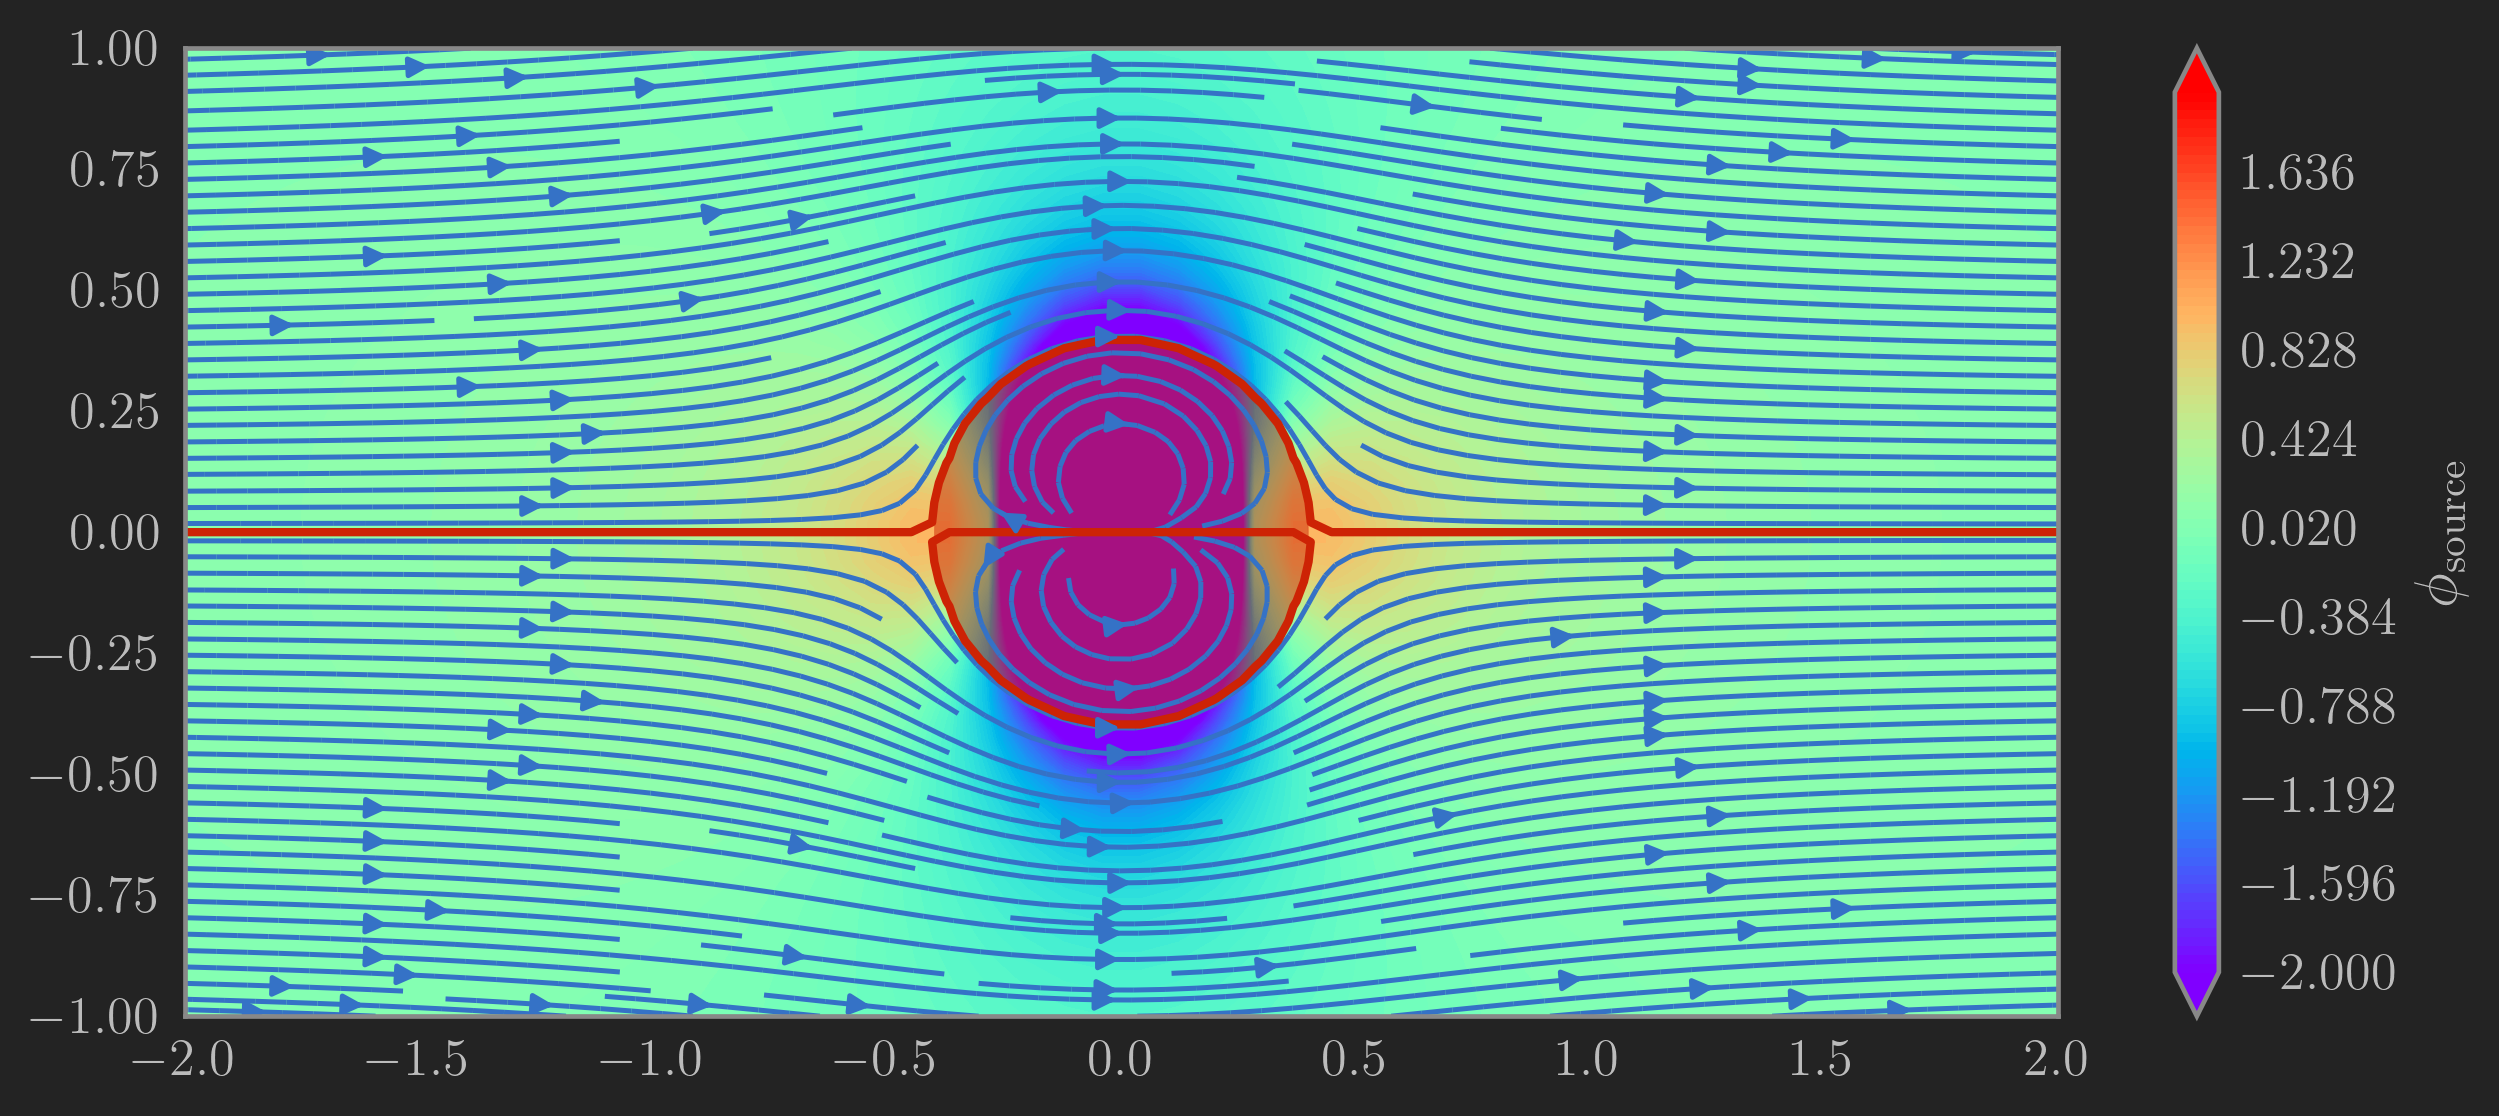

In [4]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, [ u for (u, v) in vels ], [ v for (u,v) in vels ], density=2)
contourf(X, Y, cp, levels=range(x_domain[1], stop=x_domain[end], length=100), extend="both", cmap=PyPlot.cm.rainbow)
colorbar(label="\$\\phi_{\\mathrm{source}}\$")
contour(X, Y, streams, levels=[0.], colors="#CD2305", linewidths=2, linestyles="solid")
circle = plt.Circle((0, 0), radius=R, color="#CD2305", alpha=0.5)
gca().add_patch(circle)
xlim(x_domain)
ylim(y_domain)
tight_layout();

## Panel Methods

#### Source Panels

In [5]:
x_domain, y_domain = (-3, 3), (-2, 2)
grid_size = 50
x_dom, y_dom = range(x_domain[1], stop=x_domain[2], length=grid_size), range(y_domain[1], stop=y_domain[2], length=grid_size)
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

r = 1
N_panels = 20
theta = range(0.0, stop=2π, length=N_panels + 1)
x_center, y_center = 0.0, 0.0
x_cylinder, y_cylinder = (x_center .+ r*cos.(theta), y_center .+ r*sin.(theta))
x_ends = r*cos.(theta)
y_ends = r*sin.(theta)
uniform_mag = 1.0
uniform_ang = 0.0

uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang)
source_panels = [ panelSolver.SourcePanel2D(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1]) for i in 1:N_panels ];
cylinder = panelSolver.SourcePanelSolver2D(source_panels, uniform);

In [6]:
@time strengths, vts, error = panelSolver.panelSolver2D(cylinder, uniform);
vels, pots = panelSolver.gridData(cylinder, zip(X,Y))
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);

  3.368861 seconds (11.45 M allocations: 589.004 MiB, 10.31% gc time)


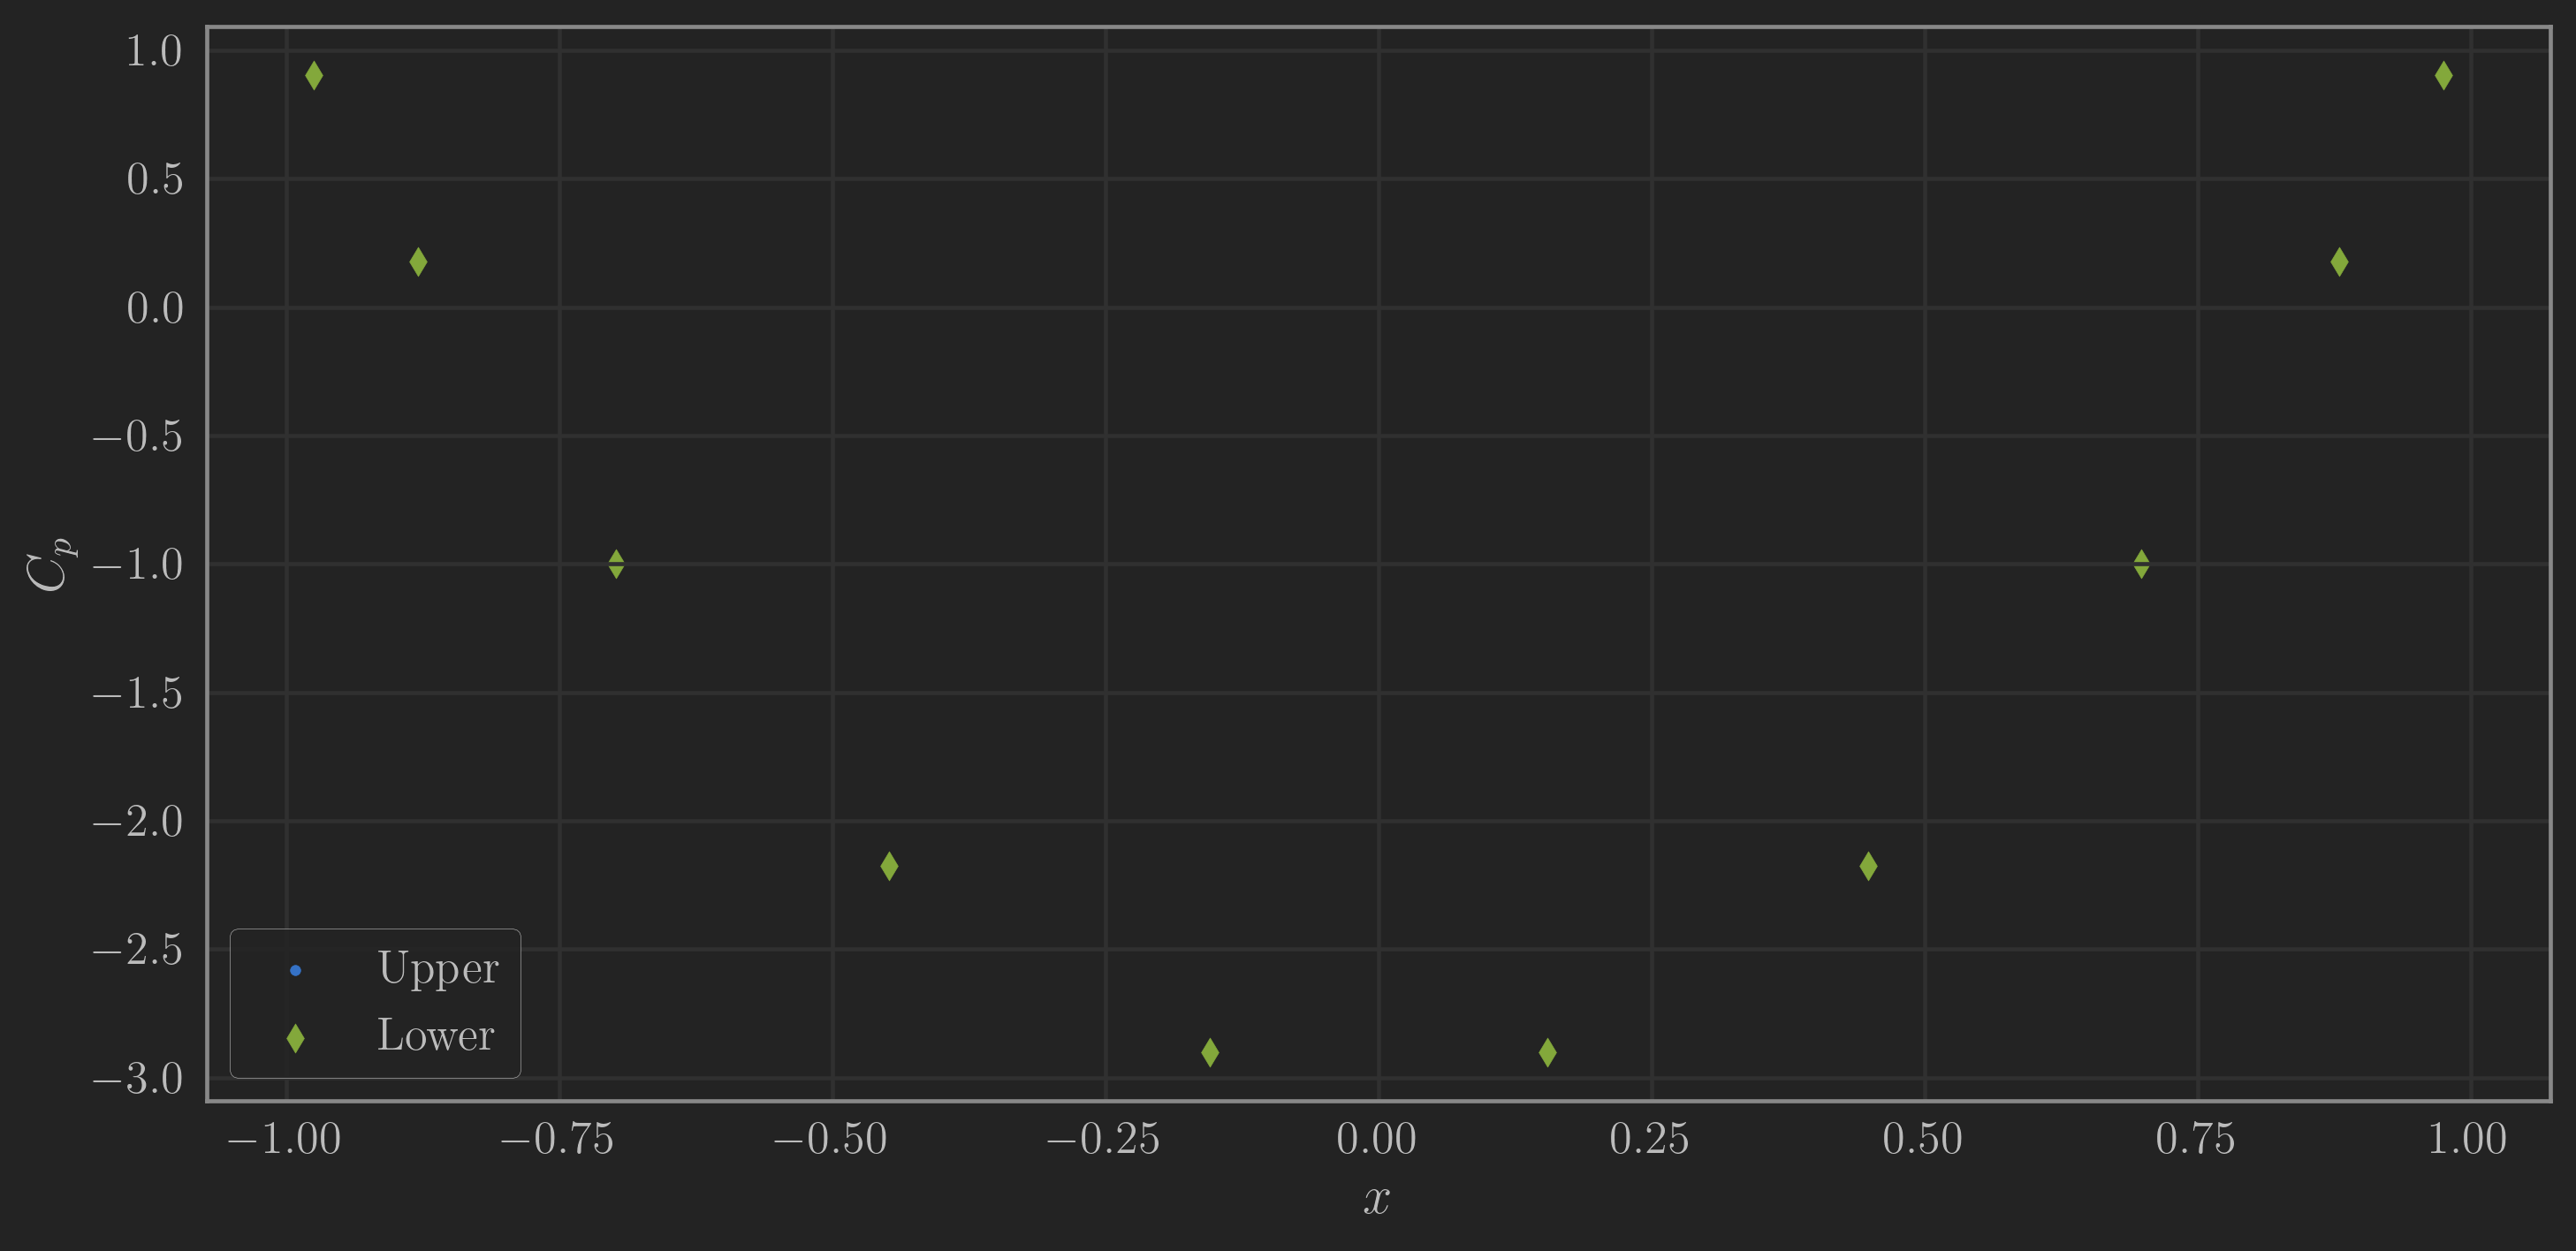

In [7]:
fig20 = figure(2, figsize=(10, 5), dpi=300)
grid()
xlabel("\$x\$")
ylabel("\$C_p\$")
# plot(x_cylinder, cp_anal, label="Analytical")
scatter([p.xc for p in source_panels if p.loc == "upper"], [p.cp for p in source_panels if p.loc == "upper" ], marker=".", label="Upper")
scatter([p.xc for p in source_panels if p.loc == "lower"], [p.cp for p in source_panels if p.loc == "lower" ], marker="d", label="Lower")
tight_layout()
legend();

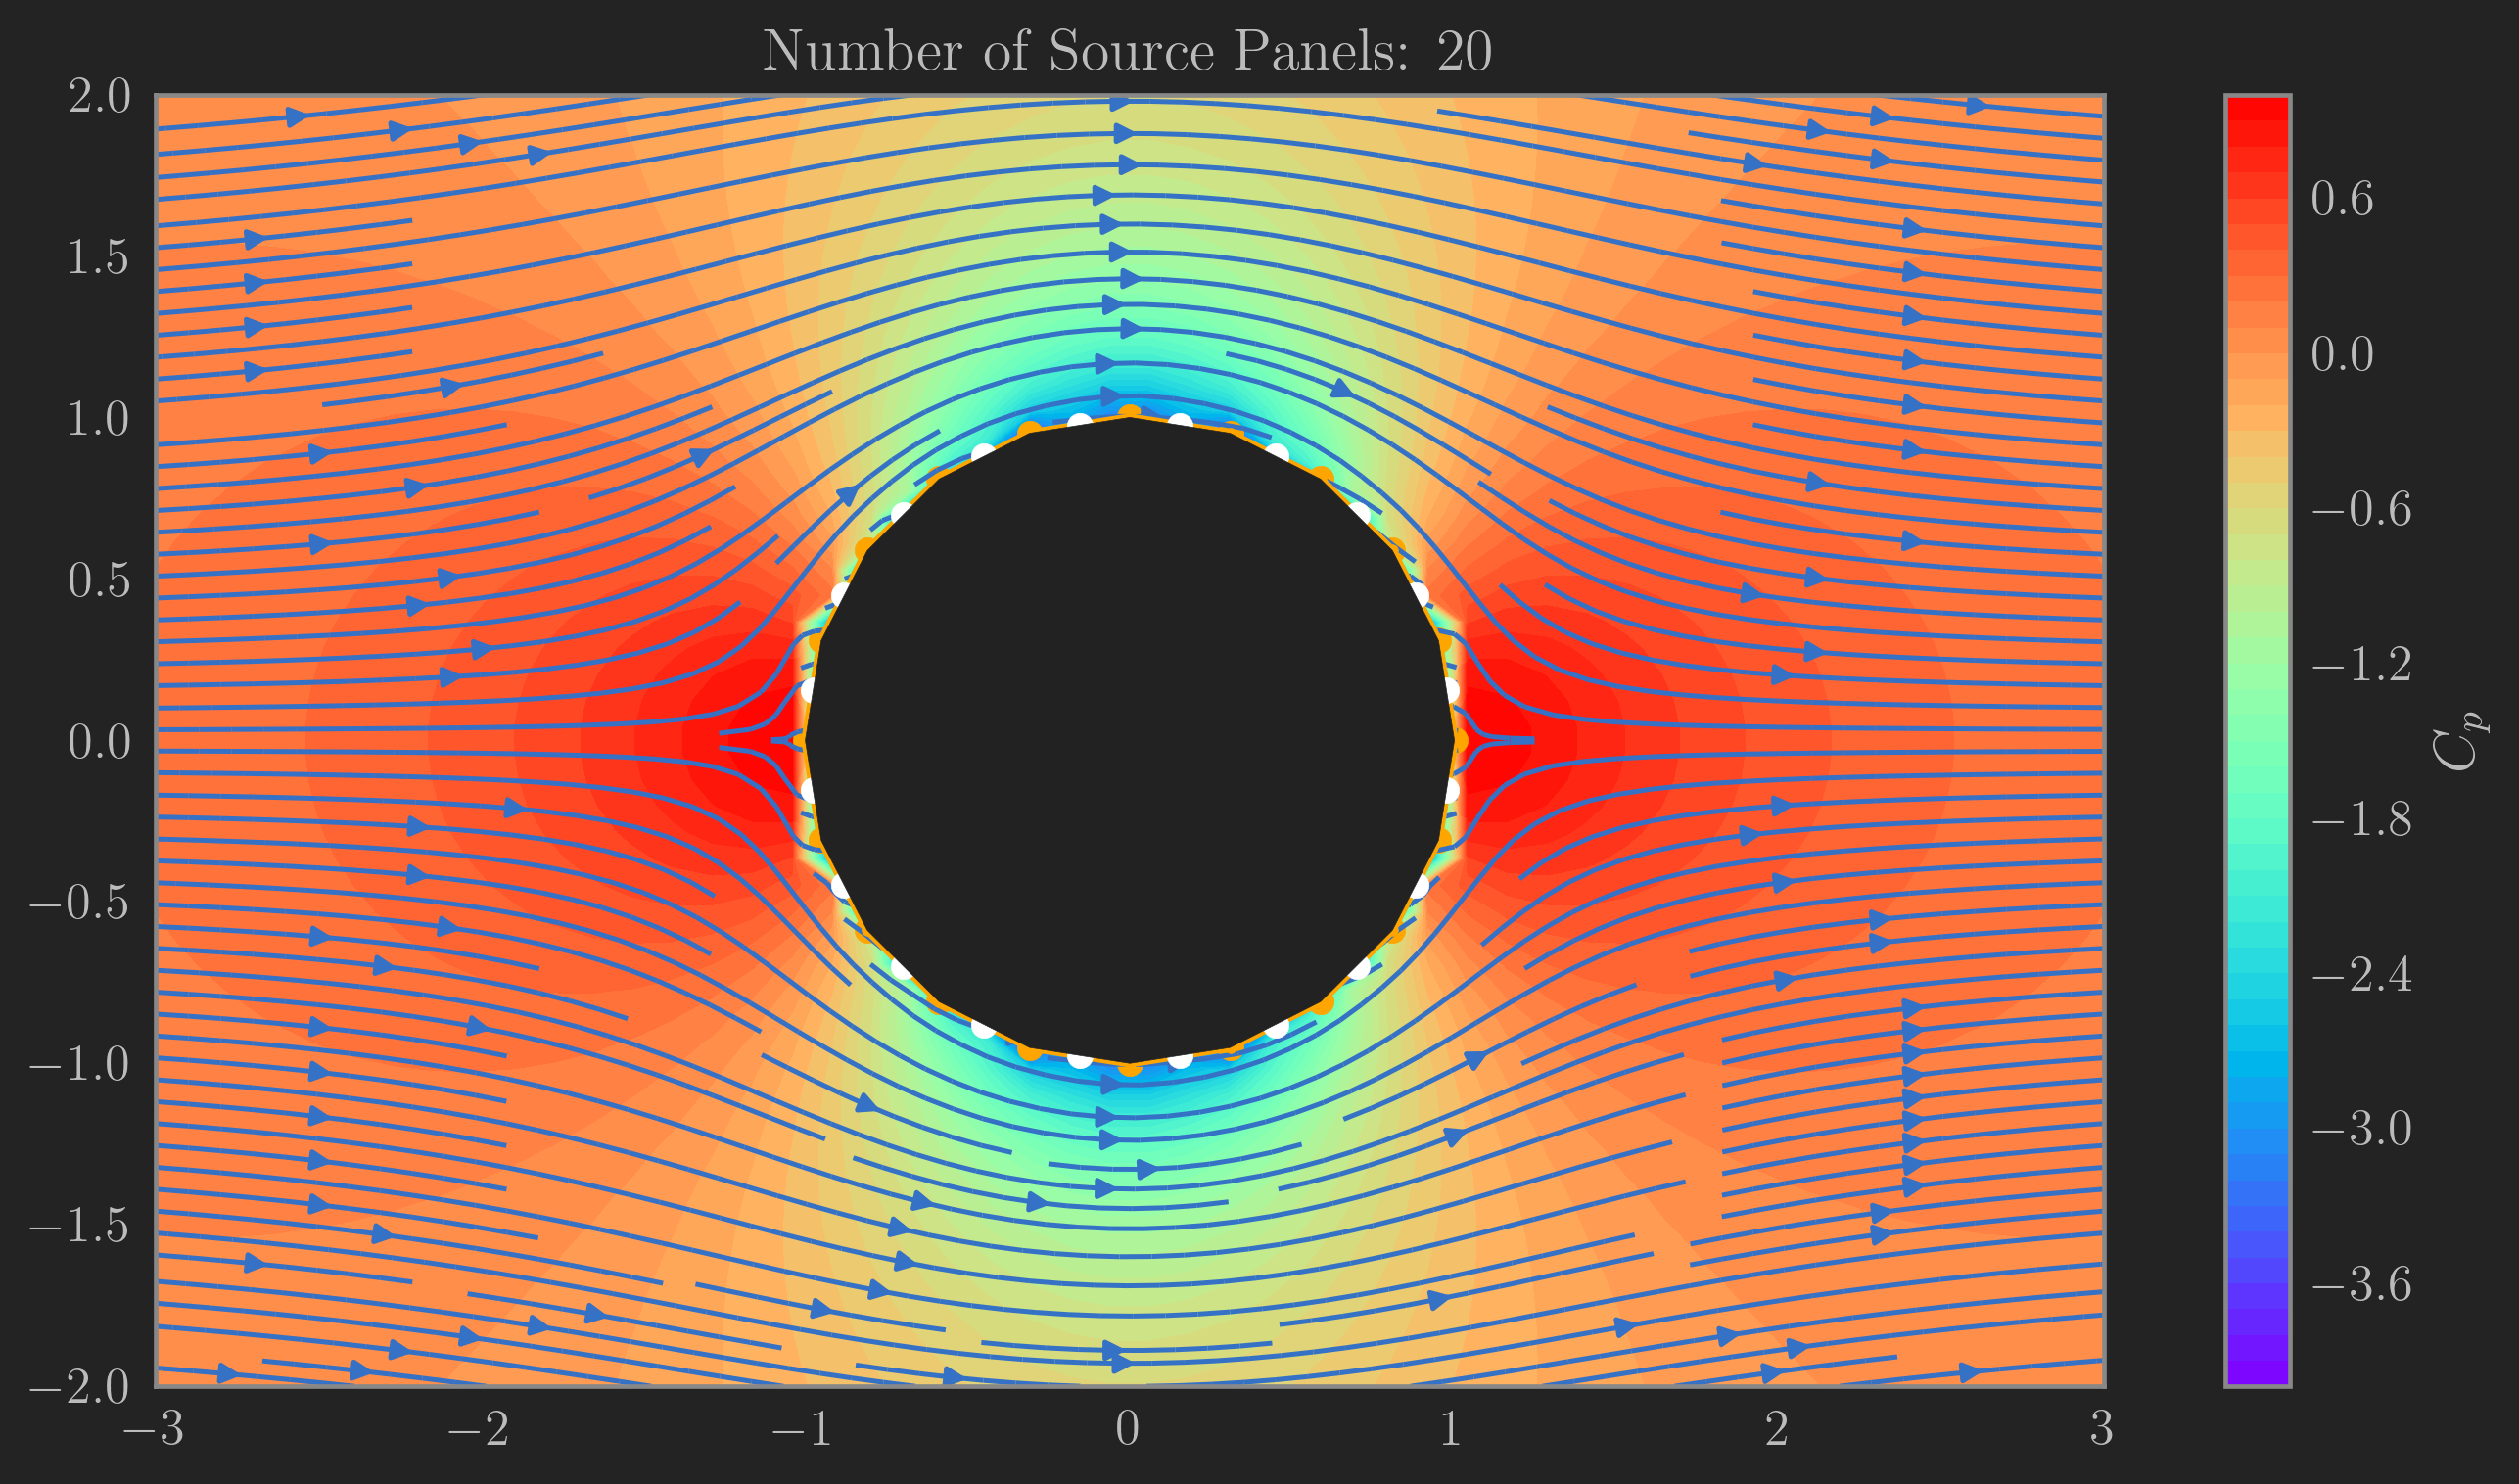

In [8]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.15width, height), dpi=300)
streamplot(X, Y, [ u for (u,v) in vels ], [ v for (u,v) in vels ], density=2)
scatter([p.xs for p in source_panels], [p.ys for p in source_panels], marker=".", label="Endpoints", color="orange", zorder=3)
scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="black", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
plt.plot(x_cylinder, y_cylinder, label="Cylinder", color="b", linestyle="--", linewidth=1)
plot(x_ends, y_ends, label="Panels", color="orange", linestyle="-", linewidth=2)
scatter([p.xs for p in source_panels], [p.ys for p in source_panels], label="Endpoints", color="orange", s=40)
scatter([p.xc for p in source_panels], [p.yc for p in source_panels], label="Center-points", color="w", s=40, zorder=3)
fill(x_ends, y_ends, color="k", zorder=3)
title("Number of Source Panels: {$N_panels}")
tight_layout();

#### Doublet-Source Panels

In [9]:
include("Modules/aeroModules.jl")
using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

true

In [10]:
coords = open("../CAVFOIL/coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end

N_panels = 80
xs, ys = panelSolver.NACA4((0,0,1,5), 1.0, N_panels, true)
coords = zip(xs, ys)
# [ print(coord) for coord in coords ]

x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("../CAVFOIL/coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

x_ends, y_ends = reverse(x_ends), reverse(y_ends)

uniform_mag, uniform_ang = 1.0, 5.0
panels = [ panelSolver.DoubletSourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);
print(panels[1].length, " ", panels[end].length, '\n')
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
airfoil = panelSolver.DoubletSourcePanelSolver2D(panels, uniform);

0.0015665164954818353 0.0015665164954818452


In [11]:
@time strengths, vts, cl, error = panelSolver.panelSolver2D(airfoil, uniform);
vels, pots = panelSolver.gridData(airfoil, zip(X,Y));
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
# print([ panel.source_strength for panel in panels ])
print("Lift Coefficient: ", cl, "\n")
print("Error: ", error)

  0.714258 seconds (1.55 M allocations: 78.977 MiB, 3.82% gc time)
Lift Coefficient: (0.6001254356558257, 0.5999830578153695)
Error: 0.015714337858969883

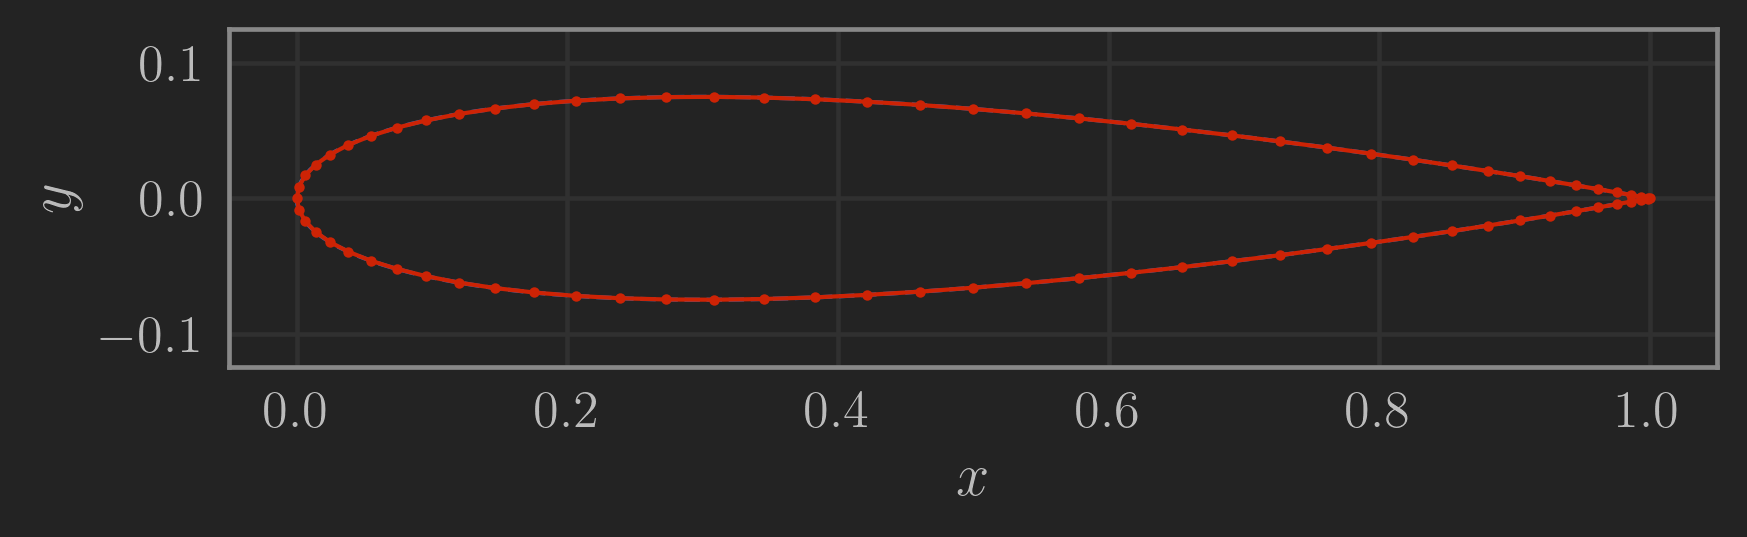

In [14]:
figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.xs for panel in panels ], [ panel.ys for panel in panels ], linestyle="-", linewidth=1, marker=".", markersize=5, color="#CD2305")
axis("scaled")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

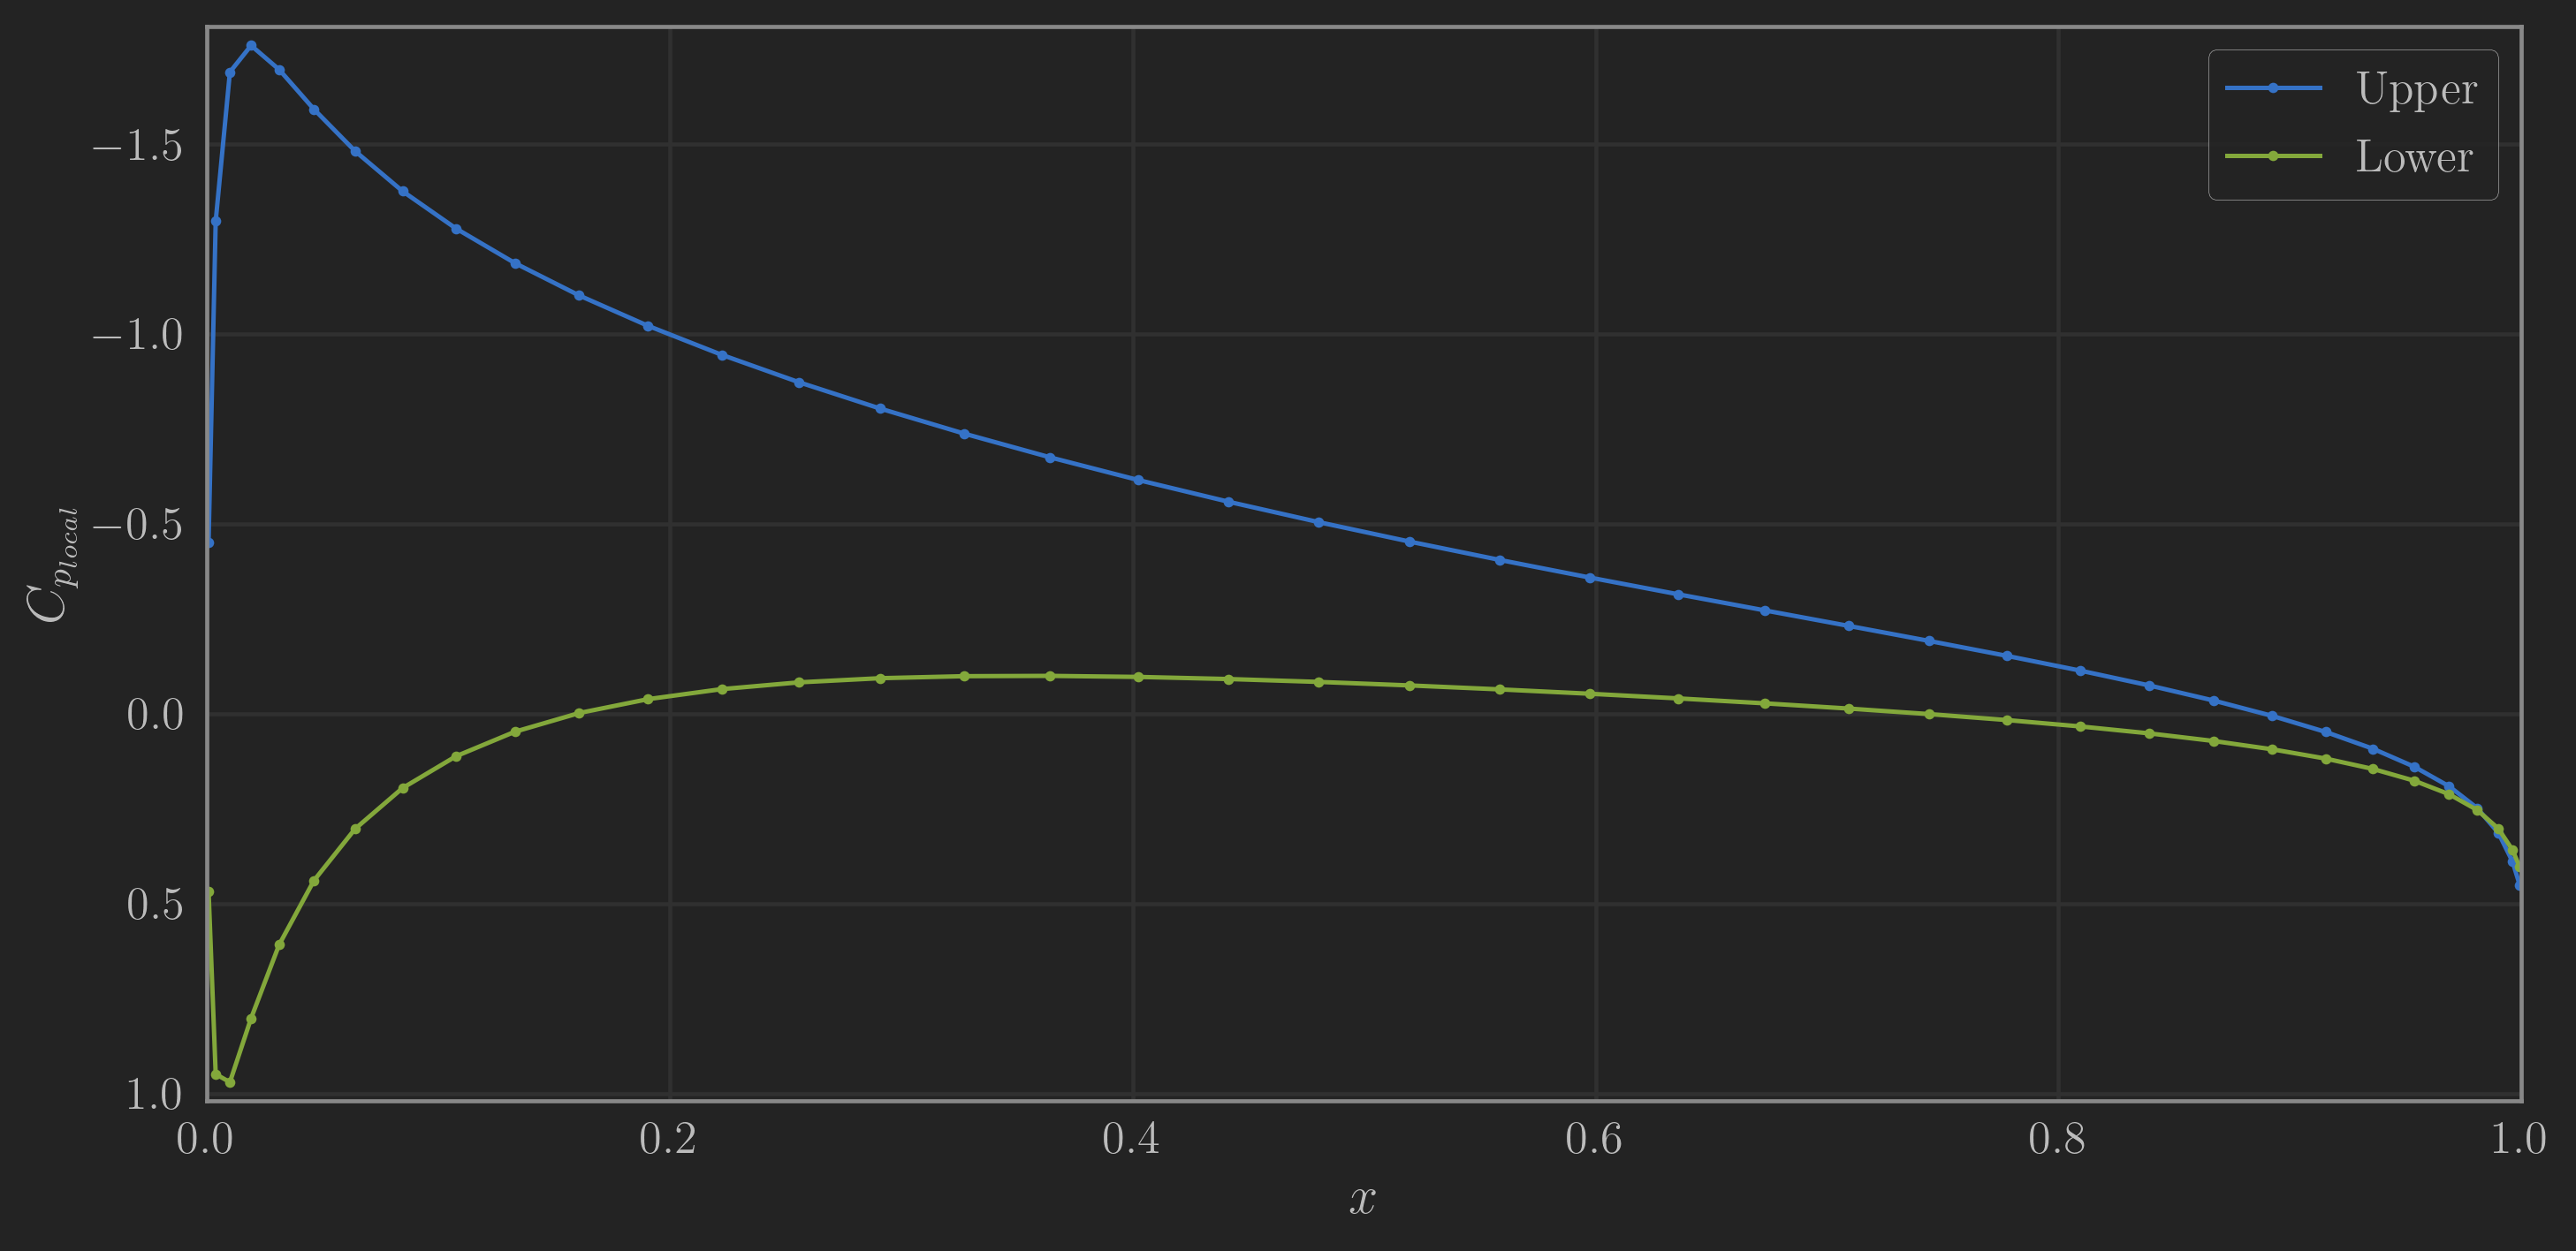

In [15]:
fig20 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend();

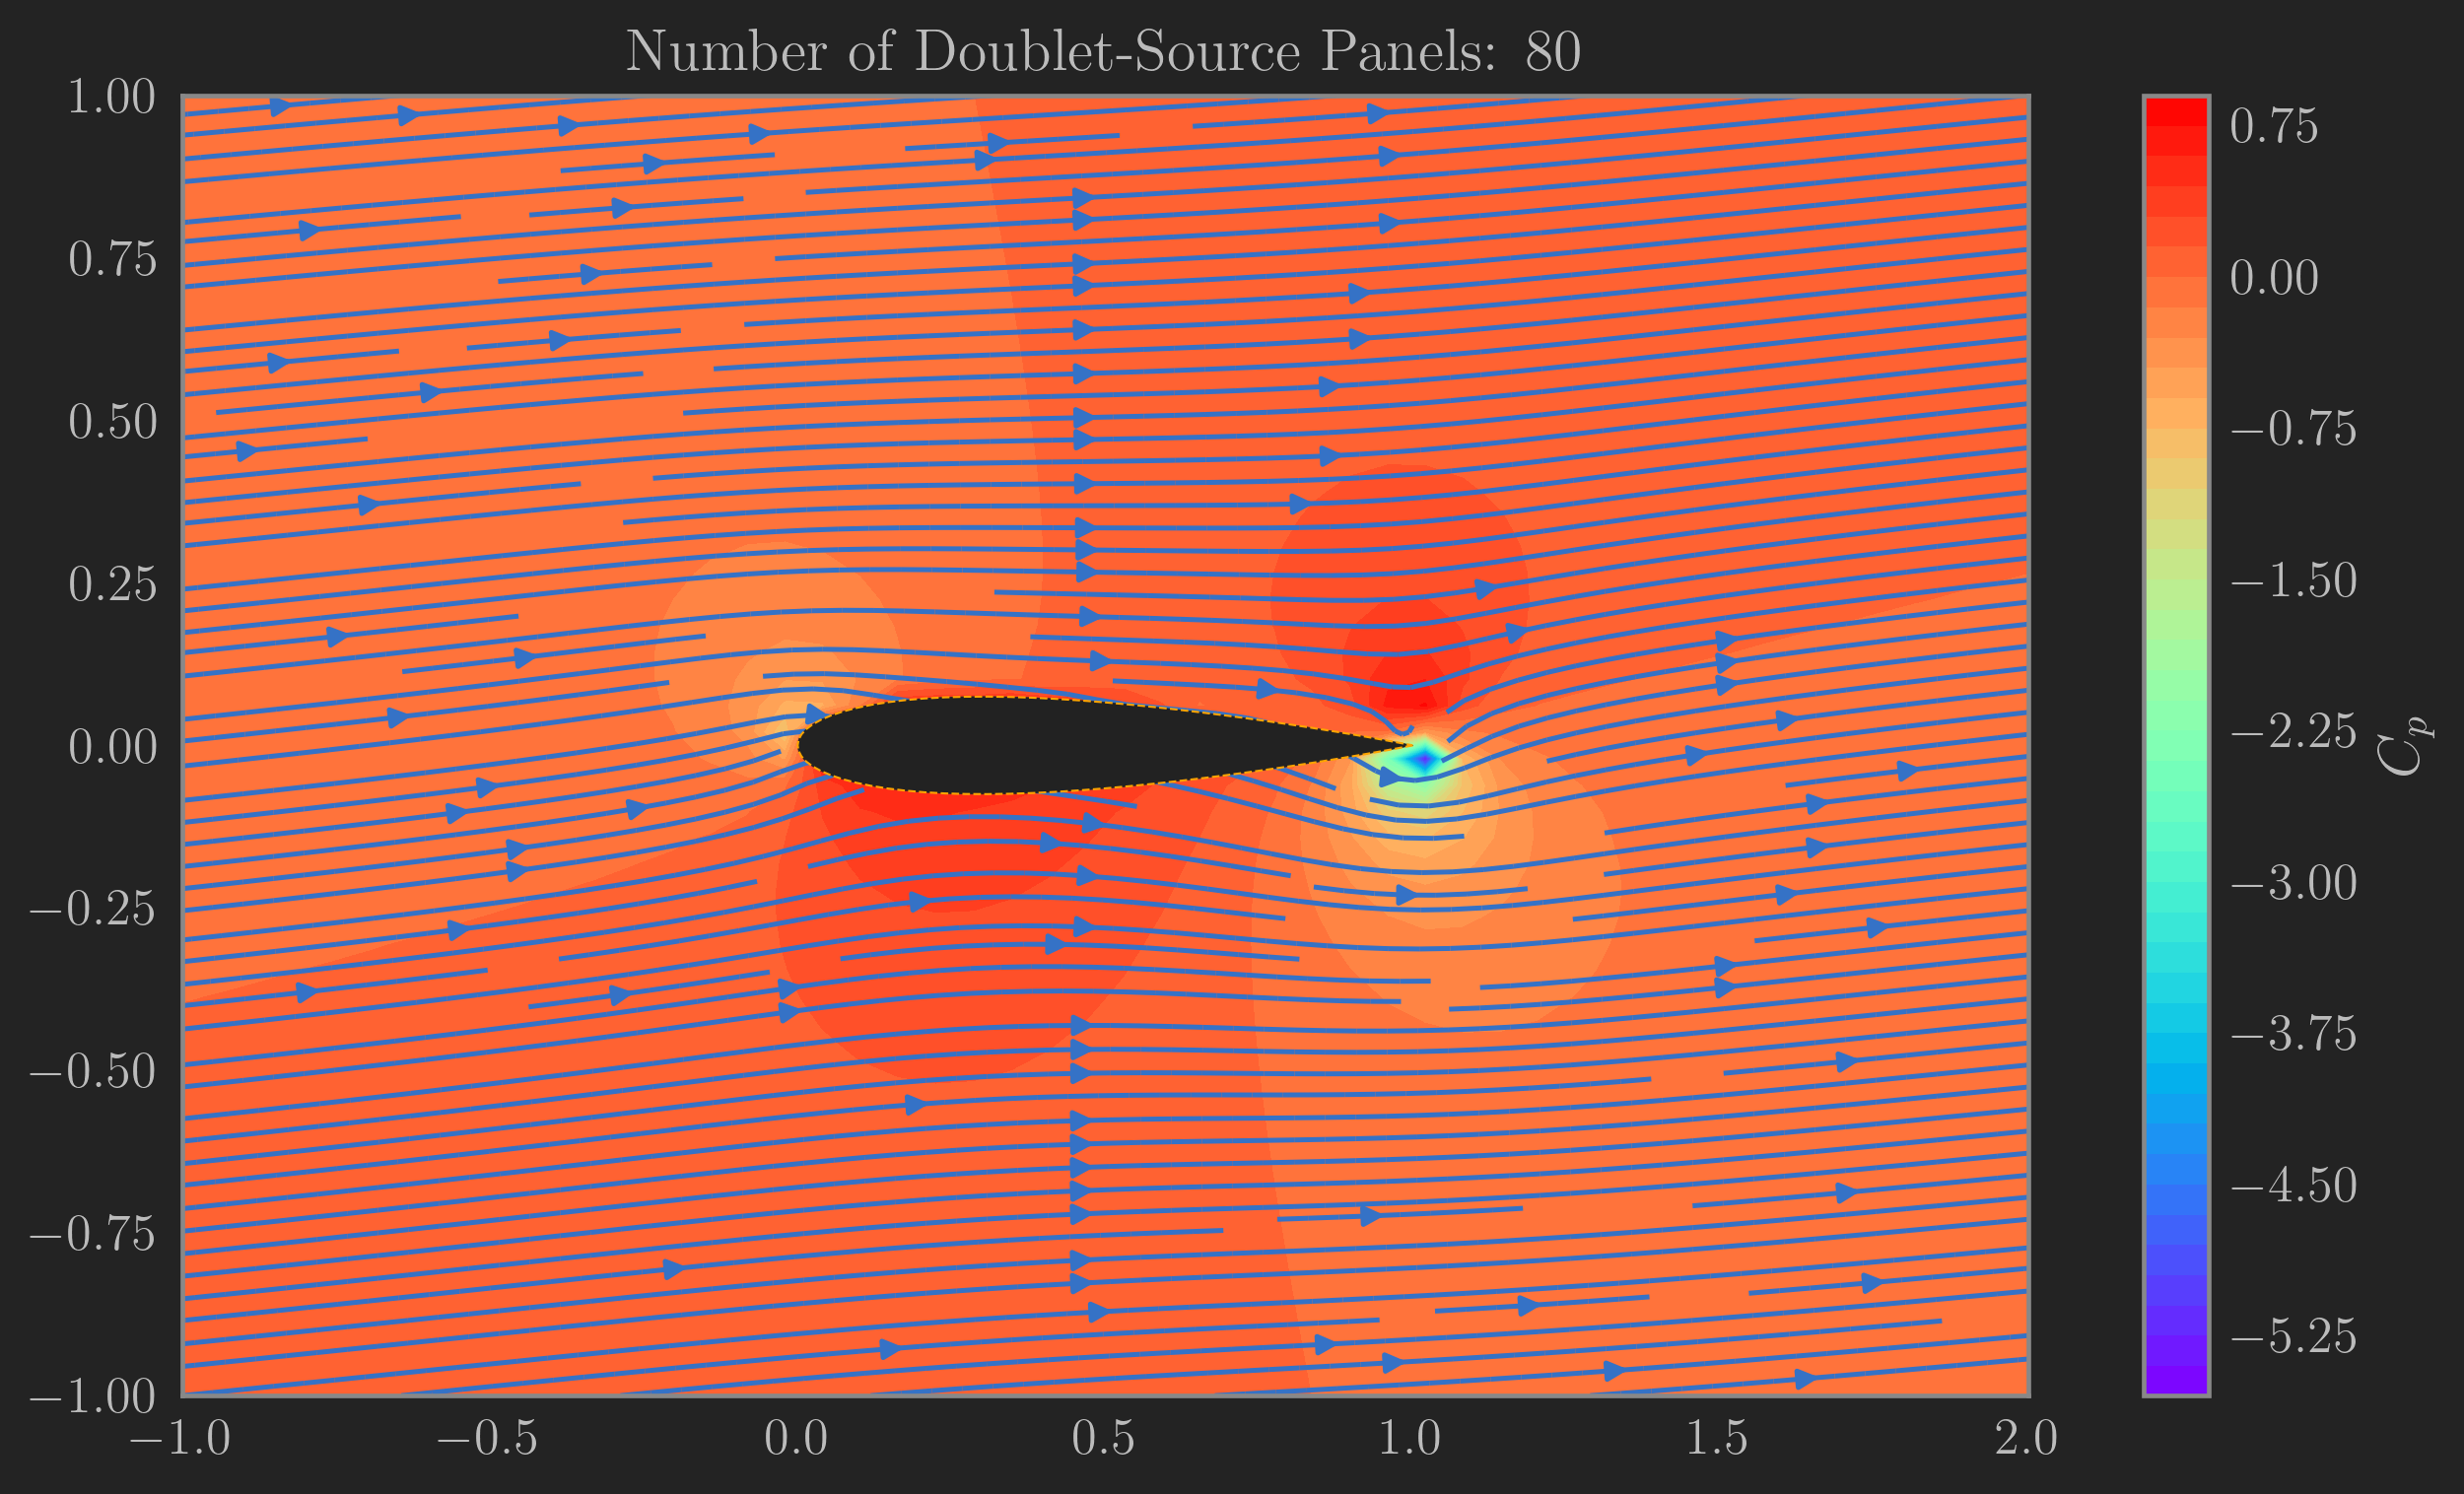

In [16]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([p.xs for p in panels], [p.ys for p in panels], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();

In [19]:
coords = open("../CavFoil/coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end

N_panels = 80
xs, ys = panelSolver.NACA4((0,0,1,5), 1.0, N_panels, true)
coords = zip(xs, ys)
# [ print(coord) for coord in coords ]

x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("../CavFoil/coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

x_ends, y_ends = reverse(x_ends), reverse(y_ends)

uniform_mag, uniform_ang = 1.0, 5.0
panels = [ panelSolver.SourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);
print(panels[1].length, " ", panels[end].length, '\n')
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
airfoil = panelSolver.VortexSourcePanelSolver2D(panels, uniform);

0.0015665164954818353 0.0015665164954818452


In [22]:
# @time strengths, vts, cl, error = panelSolver.VortexSourcePanelSolver2D(panels, uniform);
vels, pots = panelSolver.gridData(airfoil, zip(X,Y));
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
print([ panel.source_strength for panel in panels ])
print("Lift Coefficient: ", cl, "\n")
print("Error: ", error)

LoadError: type SourcePanel2D has no field source_strength

## Multiple Dispatch

In [29]:
include("Modules/functionalPanel.jl")
# include("Modules/aeroModules.jl")

using .AeroModules
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

# Grid parameters
x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

# Diamond wedge test
# panels = [ AeroModules.DoubletPanel2D((1.0, 0.0), (0.5, -0.1)), AeroModules.DoubletPanel2D((0.5, -0.1), (0.0, 0.0)), AeroModules.DoubletPanel2D((0.0, 0.0), (0.5, 0.1)), AeroModules.DoubletPanel2D((0.5, 0.1), (1.0, 0.0)) ]
N_panels = 160
coords = open("coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end
x_ends, y_ends = AeroModules.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end
x_ends, y_ends = reverse(x_ends), reverse(y_ends)

panels = [ AeroModules.DoubletPanel2D((xs, ys), (xe, ye)) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];

uniform = AeroModules.Uniform2D(5.0, 5.0)

@time (cl, kcl, cps) = AeroModules.aeroCoefficients(panels, uniform)
println("Lift Coefficient: $cl, $kcl")
# println("Pressure Coefficients: $cps")

# For plotting purposes
vels, pots = panelSolver.gridData(airfoil, zip(X,Y));

# Pressure coefficients
cp = panelSolver.pressureCoefficient2D(vels, uniform.mag);
# print([ panel.source_strength for panel in panels ])

  0.356112 seconds (964.06 k allocations: 50.610 MiB, 7.76% gc time)
Lift Coefficient: 1.1441850967551215, 1.0007629649508119


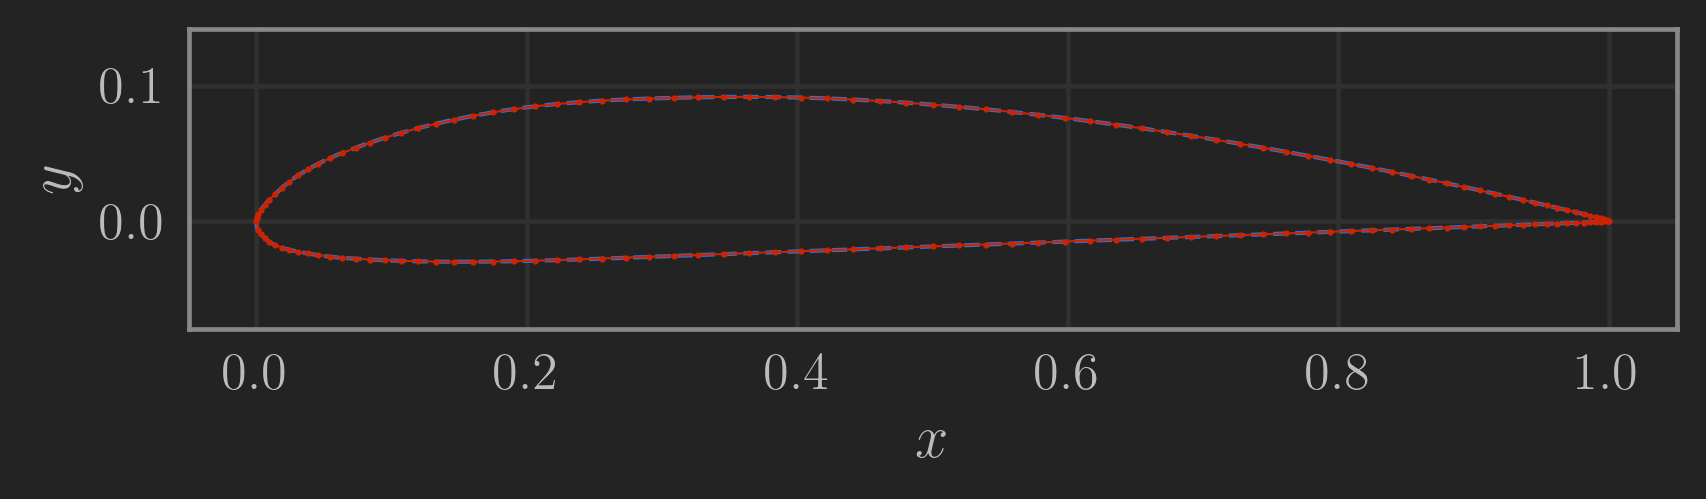

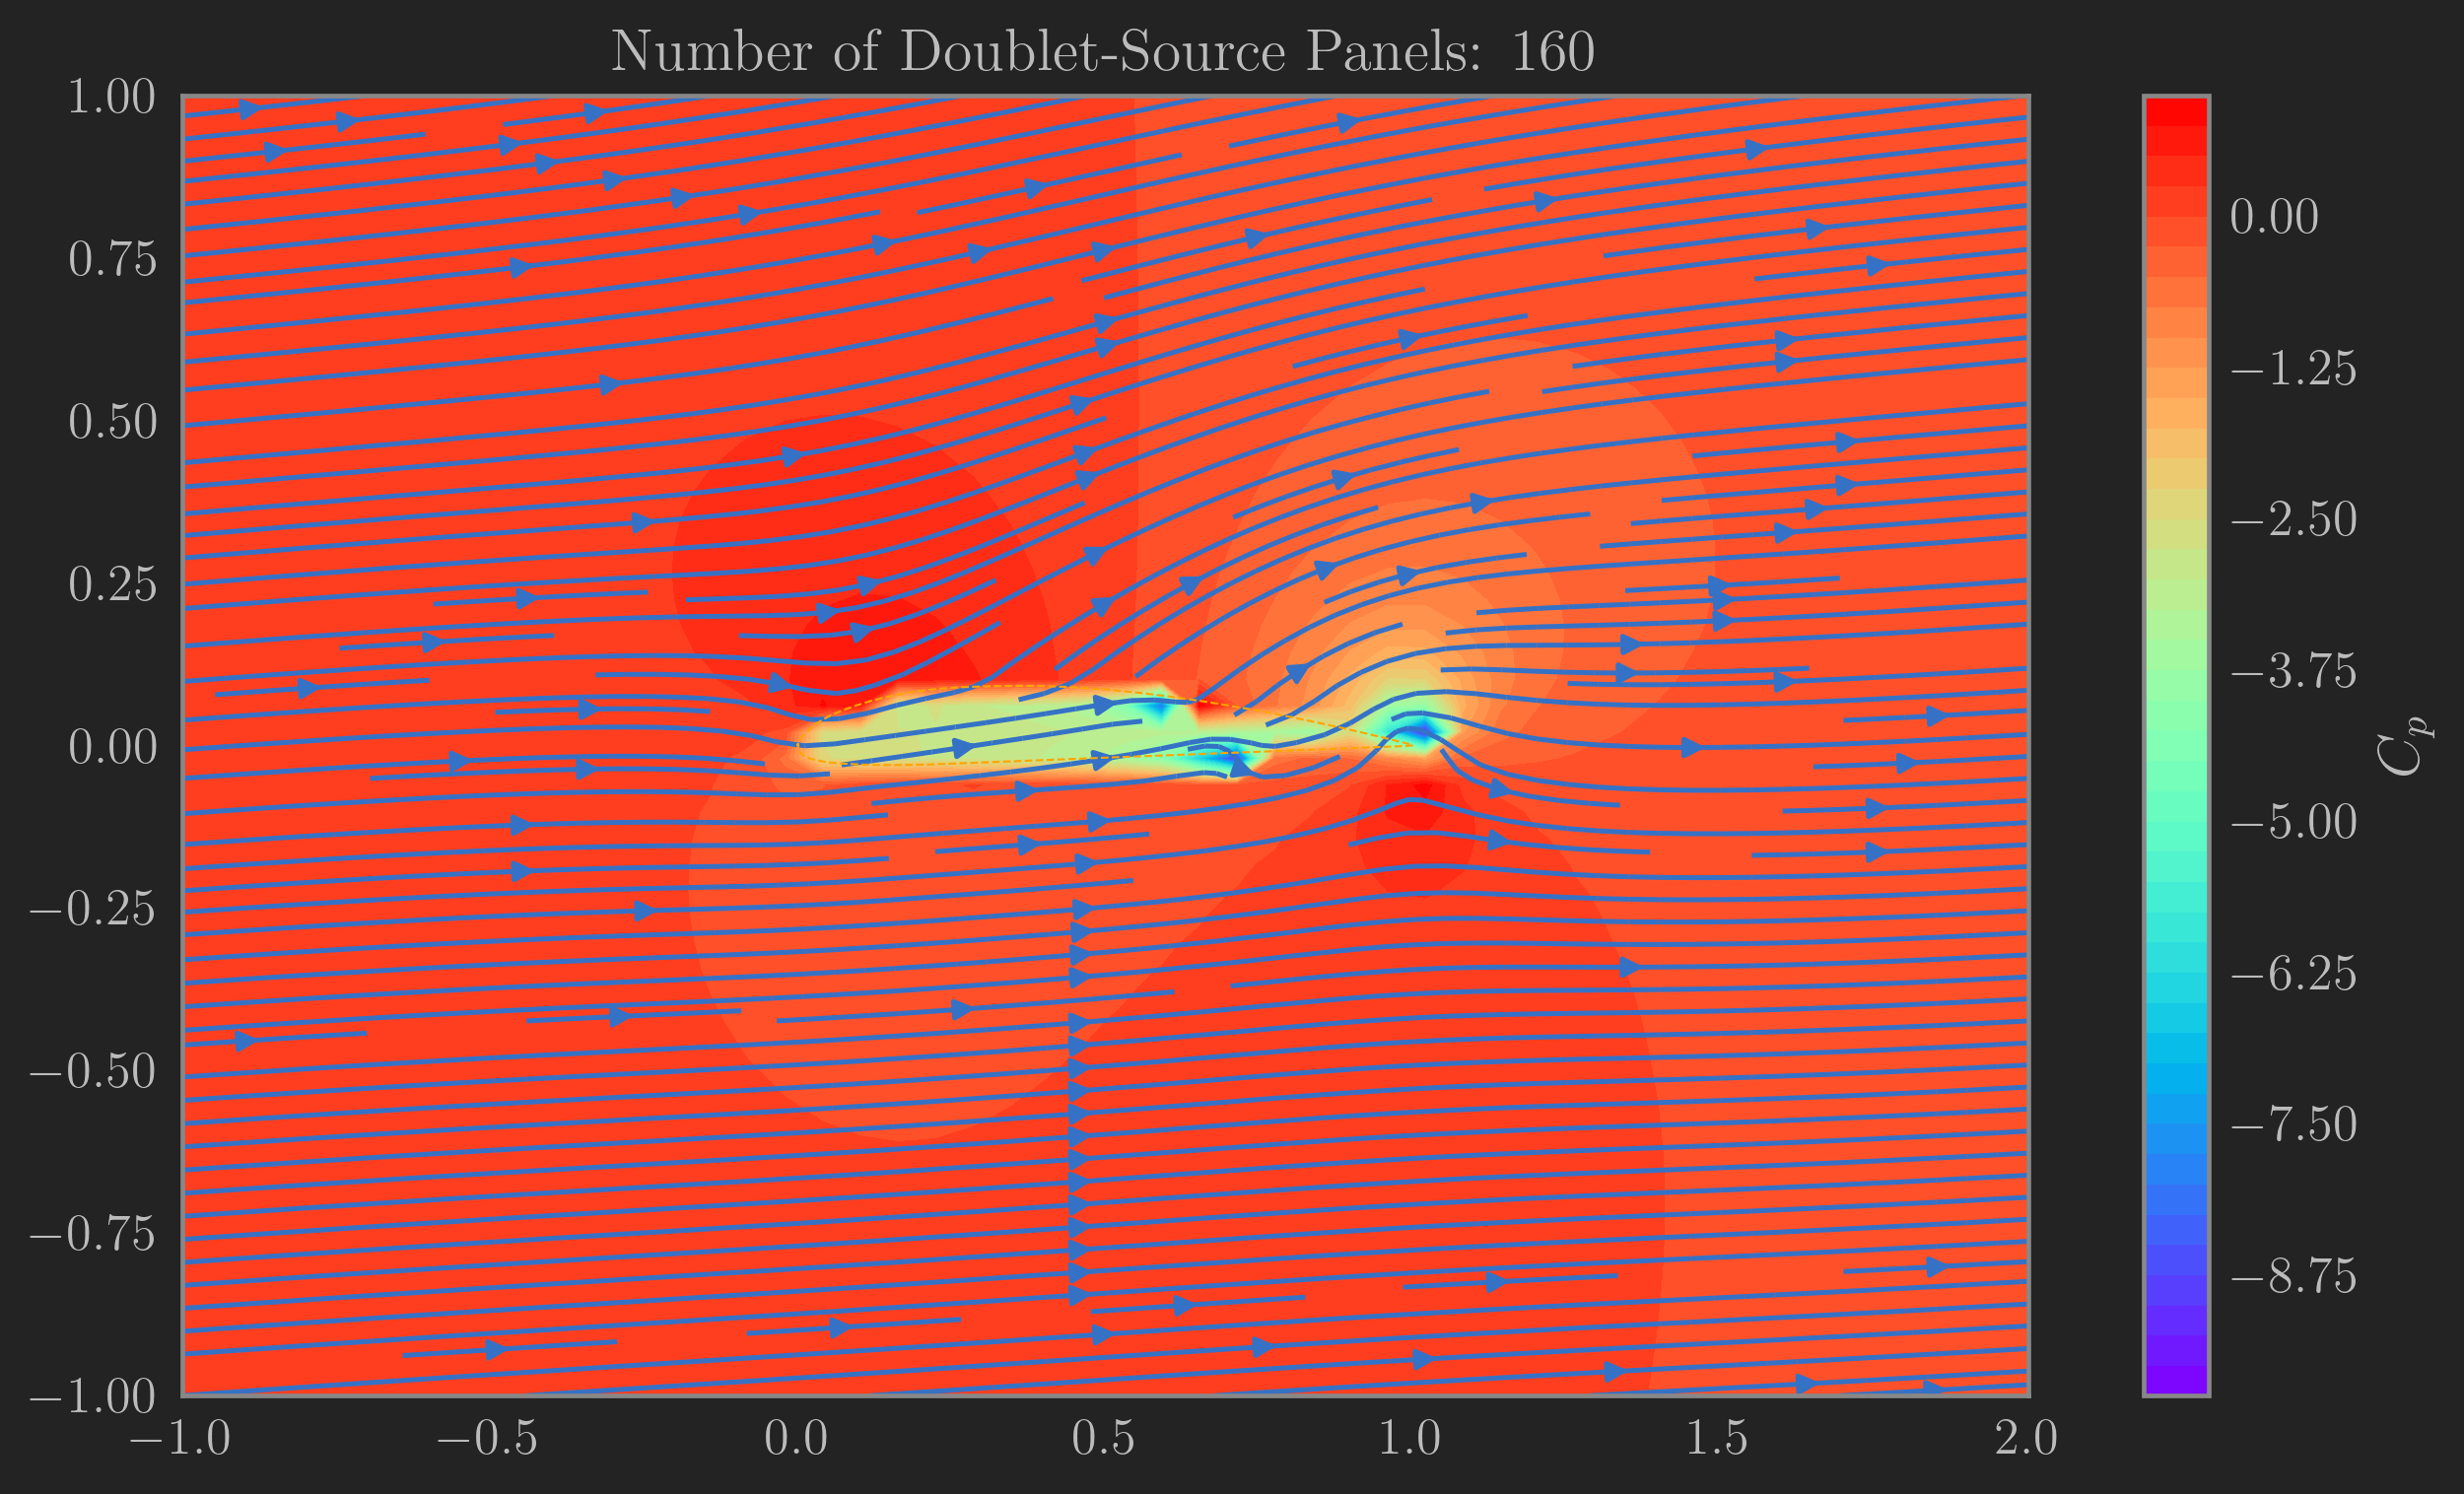

In [31]:
# Airfoil plotter
fig1 = figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords ], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.start[1] for panel in panels ], [ panel.start[2] for panel in panels ], linestyle="-", linewidth=0.5, marker=".", markersize=3, color="#CD2305")
axis("scaled")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

# Plot pressure coefficient
fig2 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend()
show()

# Plot flowfield
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig3 = figure(3, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
# fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([ panel.start[1] for panel in panels ], [ panel.start[2] for panel in panels ], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();

## OOP

In [26]:
include("Modules/doubletSourcePanelSolver.jl")
# using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

# Grid parameters
x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

# Import airfoil coordinates file
N_panels = 121
filename = "coordinates/ClarkY.dat"
coords = open(filename) do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end
# x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

# Generate NACA airfoil coordinates
N_panels = 100
xs, ys = panelSolver.NACA4((2,4,1,2), 1.0, N_panels, true)
coords = zip(xs, ys)
x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

# Generate flat plate coordinates
# coords = zip(reverse(range(0, 1, length=10)), zeros(10));
# x_ends, y_ends = panelSolver.cosinePanels([ x for (x, y) in coords ], [ y for (x, y) in coords], 30);

# Save cosine-distribution interpolated points
cosine = open("Modules/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

# File coordinates
# x_ends, y_ends = [ x for (x, y) in coords ], [ y for (x, y) in coords ]

# Reverse coordinates to follow clockwise convention
x_ends, y_ends = reverse(x_ends), reverse(y_ends)

# Using airfoil panels
panels = [ panelSolver.DoubletSourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];

# Diamond wedge test case
# panels = [ panelSolver.DoubletSourcePanel2D(1.0, 0.0, 0.5, -0.1), panelSolver.DoubletSourcePanel2D(0.5, -0.1, 0.0, 0.0), panelSolver.DoubletSourcePanel2D(0.0, 0.0, 0.5, 0.1), panelSolver.DoubletSourcePanel2D(0.5, 0.1, 1.0, 0.0) ]

# Hexagon
# panels = [ panelSolver.DoubletSourcePanel2D(1.0, 0.0, 0.75, -0.1), panelSolver.DoubletSourcePanel2D(0.75, -0.1, 0.25, -0.1), panelSolver.DoubletSourcePanel2D(0.25, -0.1, 0.0, 0.0), panelSolver.DoubletSourcePanel2D(0.0, 0.0, 0.25, 0.1), panelSolver.DoubletSourcePanel2D(0.25, 0.1, 0.75, 0.1), panelSolver.DoubletSourcePanel2D(0.75, 0.1, 1.0, 0.0) ]

# Uniform2D construction
uniform_mag, uniform_ang = 5.0, 5.0
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);


# Print panel attributes
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
# print(panels[1].length, " ", panels[end].length, '\n')

# Solve system
@time airfoil, strengths, cps, cl, error = panelSolver.panelSolver2D(panels, uniform, false, true);

# # For plotting purposes
# vels, pots = panelSolver.gridData(airfoil, zip(X,Y));

# # Pressure coefficients
# cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
# # print([ panel.source_strength for panel in panels ])
println("Lift Coefficient: ", cl)
# # DEBUGGING
# println("Strengths:", strengths)
# println("Pressure Coefficients:", cps)
# println("'Error': ", error)

[0.5 1.871189046855883e-5 2.701432605869135e-5 3.664768485970978e-5 4.5543250323841355e-5 5.3428489237674194e-5 6.015044355796332e-5 6.561961107115668e-5 6.980599567824855e-5 7.274024172766187e-5 7.451413488885818e-5 7.52793045050402e-5 7.524383050193251e-5 7.46667266850825e-5 7.385041137290005e-5 7.313137853186478e-5 7.286936755252379e-5 7.343540019495963e-5 7.519910771191753e-5 7.851580814593565e-5 8.371381244936129e-5 9.108243861372128e-5 0.00010086119645744295 0.00011323057368694155 0.00012830480799761663 0.00014612697180259318 0.00016666662681564905 0.00018982022593571458 0.0002033266657727985 0.00020242913604796286 0.00020893626191255524 0.00022200972032141084 0.0002406641067441969 0.0002639844887092639 0.0002911268690757484 0.00032132348379650013 0.00035389106615297926 0.00038824044932897223 0.0004238861200388229 0.0004604545956438198 0.0004976907810767972 0.000535461769235611 0.0005737578855790034 0.0006126911910840419 0.0006524923479597443 0.00069350856678725 0.000736212537966

 0.0008427467520819083 0.0008221373891661442 0.0008157258340467834 0.0008115751719514789 0.0008101986988720619 0.000812187345629737 0.0008182437327835238 0.0008292465396122969 0.000846346597510062 0.0008711110061319907 0.0009057424240402932 0.0009534202506017639 0.0010188469465255067 0.0011091537879292378 0.001235465253219169 0.0014157337245713974 0.001680176075902318 0.0020824393817851093 0.002724560738670266 0.0038191373542801705 0.005868120981978084 0.010291586140339565 0.022411422780186614 0.07282303288429985 0.20906036386313367 0.08619139281631592 0.023768281583881452 0.008755259611633067 0.0023709570484224474 0.012214409686295433; 5.372548525912436e-6 1.605442980849805e-5 2.6659519880088902e-5 3.786548999533742e-5 5.8969765170687544e-5 0.5 7.478130056221402e-5 6.552844474905859e-5 6.747084451347983e-5 6.954857543286906e-5 7.089043364130687e-5 7.143164108735322e-5 7.131058859342843e-5 7.07587294258622e-5 7.006569625206277e-5 6.95608912881674e-5 6.959912220130323e-5 7.0547107267691

 0.000706958486748198 0.0007523998520451623 0.0007999532616910342 0.000850396952490326 0.0009054222264972513 0.00116165455015304 0.0007533504020019859 0.0009918842016192165 0.0010071137905453143 0.0010261886470436957 0.0010467849579985009 0.0010678374658464908 0.0010885559237273203 0.0011083065379204095 0.0011265852005426541 0.0011430072936376402 0.0011573007014978555 0.001169298935021863 0.0011789336745625587 0.001186226747565484 0.0011912818070671986 0.0011942760834661675 0.0011954526489434192 0.001195113708413267 0.0011936155443589634 0.001191365926003712 0.0011888250850312825 0.001186531593255653 0.0012102923837155385 0.001258962774525768 0.001321685162548254 0.0014023638701372255 0.001506248821471511 0.001640573528321524 0.001815585736646442 0.00204623703481996 0.002355053165888808 0.002777219851029915 0.0033700539760047007 0.00423171508997325 0.005540879771603538 0.007648326584828294 0.011310873487489772 0.018359588686721478 0.03374190782817112 0.06929332001142452 0.1131528959493

7.716778961563312e-5 8.659741551212954e-5 9.864334728874611e-5 0.00011347173239799997 0.00013120396908237366 0.00015190038477401742 0.00017555240934027168 0.00020207958690935906 0.0002313302962652422 0.000245565400277208 0.00023950726689934529 0.0002450345747859495 0.00026006067562861913 0.00028267050039703853 0.0003113068129193188 0.0003446819814347254 0.0003817258960124986 0.0004215564990485226 0.0004634642175510557 0.0005069045180238358 0.0005514946903429032 0.0005970122600742386 0.0006433933804186769 0.0006907303197954288 0.0007392678847413546 0.0007893996028993726 0.000841666821207236 0.0008967728326701276 0.0009556760829803845 0.0010203794422839721 0.0013136406173228146 0.0008552285791316839 0.0011302297267263384 0.001153397099469643 0.001182063609607269 0.0012137359565301765 0.001247372397080612 0.0012822710374502525 0.0013179395398027355 0.00135407095203133 0.001390540900246072 0.001427411615359896 0.0014649401524328921 0.0015035912550381036 0.0015440566616427207 0.001587283730

4.9673430801200726e-5 5.129247684062084e-5 5.2910303611951376e-5 5.4850591832831574e-5 5.753469273253542e-5 6.162674451641112e-5 6.889730926188826e-5 9.524562063270819e-5 0.5 0.00011356361967077556 0.00010523163746130019 0.00011754671165859015 0.00013475534066248435 0.00015553229561672733 0.00017959069383718566 0.00020679206437683478 0.00023698956436398833 0.0002699891751858132 0.00028216028994765616 0.0002686718416799768 0.0002720849424023941 0.00028823644756671203 0.0003139185375553338 0.00034679790912887275 0.0003851171357332899 0.00042752484165050735 0.0004729783508322281 0.000520688034239776 0.0005700857644500448 0.0006208070587160759 0.0006726806161414363 0.0007257214776890863 0.0007801257089378375 0.0008362657859331467 0.0008946872587487155 0.0009561101107371728 0.0010214486654724112 0.001091923878918771 0.001169979753604516 0.0015127318803377105 0.0009896556072133415 0.00131402090437342 0.0013494788050869386 0.0013930769358381902 0.00144219982102292 0.0014959654180001088 0.0015

 0.00712705258866656 0.005730538809077056 0.004677395284806506 0.003861682918711321 0.0032137254844536644 0.0026865492413955124 0.0022477031929139177 0.0018742389362388504 0.00154956095500145 0.001261402194898358 0.0010004892232091814 0.0007596374773912031 0.0005331185912581325 0.0003162010871690176 0.00010480079187590464 0.010900111796844017; 3.339792846421207e-6 9.950172170452033e-6 1.6358451487907697e-5 2.244619617230008e-5 2.811805312756484e-5 3.330976842682234e-5 3.799506637467838e-5 4.2191117674956574e-5 4.59623653656825e-5 4.942253132016289e-5 5.2734695685308575e-5 5.610943027624287e-5 5.980108247987964e-5 6.410246787271775e-5 6.933848745929535e-5 7.585967475762343e-5 8.403779257062562e-5 9.426860127223415e-5 0.00010699644741995027 0.00012281191869527587 0.0001428566212493941 0.00017116998833027736 0.00024999048137784027 0.5 0.0003070989195706023 0.0002848324829469061 0.0003132186817469705 0.0003497540005633886 0.0003462644174287362 0.0003059918709135573 0.00030502854007101584 0

 0.004182370933159716 0.004679609770052073 0.005292126813880008 0.006059220651165312 0.0070370784285710974 0.008306962994783795 0.009987286793213871 0.012249958397059467 0.01533695369053274 0.019555970192726507 0.025182477765413804 0.03209371694663138 0.0389945366109063 0.042996795360063504 0.04153750804287641 0.03554750680607706 0.02820873977327229 0.021728419807719737 0.016718202944734663 0.013022739978330408 0.010317748469452425 0.008318399726100474 0.006815626035370653 0.005664302106192615 0.004764956848416788 0.0040490534277863 0.003468752100415673 0.0029901169853773614 0.0025886610750760473 0.0022464151075280558 0.001949979148125688 0.0016892095902551537 0.0014563205655742828 0.0012452586083234293 0.0010512595609441574 0.0008705283097968662 0.0007000020331153117 0.0005371705620469685 0.00037993585500619104 0.00022649809530865176 7.525954607976534e-5 0.010199887778491349; 3.765912489723404e-6 1.1249572734120948e-5 1.8593798621575985e-5 2.5720891107955435e-5 3.2574865247101015e-5 3

 0.0008267519448372347 0.0008926496702698907 0.0009771502867376644 0.001069280296993698 0.001166992665900835 0.0012702605581132544 0.0013798908554484156 0.0014972463827164879 0.0016241904756157549 0.0017631081650016133 0.0019169690216725532 0.0020894319290153504 0.002285027600663684 0.0025096089607060364 0.0027728552750840795 0.0037209031529409826 0.0025396826435819756 0.0035117858207915835 0.0038097220854896993 0.00418566079553232 0.004648249177446105 0.005215998841211502 0.005916132059364609 0.006787212921577706 0.007883349183379205 0.009279933393007866 0.011080478382083644 0.013421941194205061 0.016469510979519854 0.02037599118089937 0.025152578686985463 0.030389996155779888 0.03493226305509643 0.03706720034424132 0.035739546218350765 0.031612382212822566 0.02637791622531643 0.021390853169525145 0.017176178236612015 0.013823408023336443 0.011236930543200158 0.009247710570597952 0.007707170418059171 0.0065002099009969965 0.005541789383821927 0.004770046386115203 0.00414000557589102 0

 0.002670398255102927 0.002428923978423481 0.002213973451999346 0.0020212898701390033 0.001847355939416547 0.0016892327383495123 0.0015444391394000999 0.0014108616579743382 0.0012866871131538564 0.001170352330467337 0.0010605064748786294 0.0009559826103824892 0.0008557758413696388 0.0007590259722475204 0.0006650030770921689 0.0005730947368004435 0.0004827940028189866 0.0003936874014058163 0.00030544251176629287 0.0002177948417963075 0.00013053388952791696 4.3488417061440485e-5 0.006277474013380102; 6.980791242520379e-6 2.0933972964235724e-5 3.486619722959654e-5 4.8776524561108684e-5 6.268258895245471e-5 7.662683709400969e-5 9.068163724251973e-5 0.00010495298649456744 0.00011958258292561664 0.00013474807515221336 0.00015066135527220343 0.0001675648196885267 0.000185725582679904 0.00020542768513498005 0.00022696238972845455 0.0002506166867717201 0.000276660143211475 0.00030533019972497433 0.00033681594284357927 0.0003712402294767377 0.00040863978800066285 0.0004489425118253072 0.00049194

 0.02445812924726592 0.027293679479559994 0.029253153414976932 0.029621377766510082 0.028226263655466658 0.025515781592561373 0.02221699237735036 0.01893597173169781 0.016005561905246143 0.013535675849977292 0.011513581319019126 0.00987780274633885 0.00855704571954548 0.007486372979588203 0.006611987530589141 0.005891230058794036 0.005290958210551675 0.004785639945003349 0.004355642444896179 0.003985840472334558 0.0036645084777431696 0.0033544297891911733 0.0030638878155496807 0.0028063249474123255 0.002576548236665728 0.0023703476519438284 0.0021842838579873586 0.002015514643361138 0.0018616611955011313 0.0017207055338433674 0.0015909123543576733 0.001470770032846031 0.00135894666607013 0.0012542578815993022 0.0011556437890079176 0.001062152932220222 0.000972931478048284 0.0008872161713171621 0.0008043298261151833 0.0007236783230116293 0.0006447482561611202 0.0005671045311036744 0.0004903873600055043 0.0004143082400554181 0.00033864463471235183 0.00026323320673454146 0.000187961575063

0.0012302475002601144 0.0013561955621280552 0.001494411534745566 0.0016462083585816211 0.0018330978031930122 0.0020763801436603363 0.0023512130946921435 0.0026629260710411442 0.00301880719137174 0.0034282970605011426 0.0039036699682389745 0.004460924716854331 0.00512093631729345 0.005910905687035149 0.006866080989730016 0.00803153886719594 0.00946334923361036 0.011227392220886754 0.013391942558523991 0.016006469855437192 0.019055276916523544 0.022378877350293497 0.025590687985627605 0.028105451709697145 0.029542542820571425 0.04471108516780371 0.5 0.030596017787888077 0.022367580361330124 0.01864715924848276 0.015643891915371348 0.013179843960988657 0.011185585494721423 0.009584606957025187 0.008300974690652569 0.007268063563517662 0.006431275147940928 0.0057474307319814325 0.005182976961651683 0.004712035241734195 0.004314684003268186 0.0039755692498130695 0.0036828243983594716 0.003427245967157103 0.0032016690136877444 0.0030004942337429467 0.0028193287398075024 0.0026546870897273173

0.017847739245004973 0.01490917938528326 0.012580120305790752 0.010813564793671598 0.011336798099432796 0.006126097093218642 0.00708777143957114 0.006196647763915223 0.005498133858769408 0.004947383946571346 0.004527706641246087 0.004278543419062035 0.004858994007687915 0.5 0.004447945079865264 0.0032994805856554938 0.0030018482758213676 0.0028140845847236754 0.0026664822063920176 0.0025406775498825846 0.0024290485660998346 0.0023274841741619213 0.002233411777992287 0.0021450875807087935 0.002061280667738205 0.00198110574153158 0.0019038910084112697 0.0017957356710275193 0.0016765114257959166 0.0015682790294860164 0.0014691338905998671 0.0013776535579597268 0.0012927485280684462 0.0012135524148991716 0.0011393475878478782 0.0010695147879592475 0.0010034994660042295 0.0009407900825682829 0.0008809051170484251 0.0008233864618946133 0.0007677974653506053 0.0007137242675071605 0.0006607793325939108 0.0006086062648832347 0.0005568851370443964 0.0005053376773401421 0.00045373176761208405 0.0

 0.002268162577364207 0.00259053763310677 0.0029709729084410894 0.0034237044204372545 0.00396744997614518 0.004627129097289884 0.005436283071720467 0.006440428202404569 0.007701521553569675 0.009332197517705124 0.011470304727301123 0.014205349675362841 0.017660020591036323 0.021862608130032844 0.026559455755382586 0.030965914503547926 0.03376584089749009 0.03380799732263084 0.031096486559182103 0.026786681225225904 0.02219273329205523 0.018095663611399835 0.014746989600719755 0.012118046009895168 0.010086500562619082 0.008522817397873781 0.007318842689949411 0.00639238929235654 0.005684454469247895 0.0051579799583211065 0.005700317486277726 0.003242925727321512 0.003883040403825979 0.003542199160597106 0.003270356291711671 0.003048799736120511 0.002866723243809182 0.002716158178637634 0.0025911473863015288 0.0024876724925336543 0.002404465118462257 0.0023469374742968725 0.0023503591341391644 0.0028255013853003743 0.5 0.0027252432472347297 0.0021014878067393563 0.0019652596757165235 0.0

 0.00020199327206443815 0.00015805461709042726 0.00011342347767106461 6.827086323251105e-5 2.2793822661849907e-5 -0.016969689710204114; 4.230253426604221e-5 0.00012735244379541343 0.00021375585459195362 0.0003024776900284069 0.0003945783276229031 0.0004912561424329715 0.0005938950412141278 0.0007041193455879865 0.000823859226797572 0.0009554311184825306 0.001101639298710608 0.0012659073840491325 0.0014524521931726638 0.0016665178956779575 0.0019146964627318236 0.0022053725762444386 0.002549349490915627 0.002960740162227523 0.003458250052840917 0.0040670407759854765 0.00482145340822949 0.005768985274392799 0.006976016793812336 0.008535712424528902 0.010577712701081134 0.013275989401397214 0.016840984473393824 0.021455576602772048 0.02709671941540199 0.033027734641067334 0.037376408907613574 0.03806950358523507 0.03474196332705453 0.029155900594112952 0.023366071794929756 0.018442186103662425 0.014604937004383655 0.011713045018546456 0.009549278443876708 0.00792217331170547 0.00668623654

 0.0014292484601912583 0.001405867309492016 0.001393666744484459 0.0014939028947637593 0.5 0.0012532948534950308 0.0009562014135064096 0.0008822615777876402 0.0008339444458414469 0.0007933965094049381 0.0007565029777182678 0.0007218519663189532 0.0006887903632893636 0.0006569160227825232 0.0006259132882211758 0.0005954940962956858 0.0005653778447845727 0.0005352874784031964 0.0005049529647923175 0.00047411819355333085 0.00044254925092965887 0.0004100428600854916 0.0003764341844731506 0.00034160341988167956 0.0003054807525845948 0.00026804938131083845 0.0002293464094018871 0.00018946151878210322 0.00014853344171705408 0.00010674434892076895 6.431237054826807e-5 2.1482555984978582e-5 -0.0210816527043981; 6.079625001773473e-5 0.0001833148837700174 0.0003086573007931139 0.0004388585284965978 0.000576191900665651 0.0007232860388310805 0.000883266853485368 0.0010599370981878551 0.0012580113123736609 0.0014834322360192194 0.0017438076504832064 0.0020490268748448444 0.002412148455324636 0.0028

 0.0014165721751982316 0.0014043237559467946 0.0013959043936851965 0.0013897922101868347 0.0013847238038830556 0.0013796350170713612 0.0013736294982645638 0.001365952868099468 0.0013559659656363337 0.0013431137527263864 0.0013268863915914858 0.0013067672577403112 0.0012821587793007804 0.001252269195880232 0.001215927224168909 0.001171256519483056 0.0011150598808369026 0.0010415550009187566 0.0009395760923872717 0.0008724875481647895 0.000845195555057812 0.000823424253909546 0.0008205355892887122 0.0009824872542808863 0.5 0.0009248956130365996 0.0007080623230485487 0.000654721288045689 0.0006200466711836583 0.0005906645181861286 0.0005633052100733212 0.0005367058443365611 0.0005101894287953655 0.0004832993074290098 0.0004556848284689995 0.0004270630608305083 0.00039720718498247943 0.0003659448387695484 0.00033315987023325663 0.0002987946019487277 0.00026285119838018195 0.0002253914164745604 0.0001865343889563404 0.00014645232162778673 0.00010536415343353072 6.352736056307106e-5 2.122819

 0.005320570381142907 0.0043010672806210876 0.003560024316789 0.0029894217665386125 0.00252793337906105 0.002175768912101814 0.0019051044796674539 0.0016960609042206197 0.0015342901131534326 0.0014092147624017149 0.001312896717011012 0.0012392945445678816 0.0011837669209983507 0.0011427343780195305 0.001113444562002379 0.0010938060012051164 0.0010822677160610959 0.0010777299192736899 0.0010794763641597779 0.0010871229237901054 0.0011005815048634798 0.0011200496167125633 0.0011460942293672865 0.0011805103405433902 0.0014691802854013645 0.0009281755459628497 0.0011986344796114452 0.0011911231950883512 0.0011897659238555428 0.0011914736051613535 0.001194744127153766 0.0011984213376358569 0.0012015377008066615 0.0012032724619392894 0.0012029306837507585 0.0011999258286684391 0.0011937612473717613 0.0011840086898612765 0.0011702824531968695 0.0011522074750559572 0.001129378819814465 0.0011013084482927396 0.0010673524892744213 0.0010266075711712515 0.0009777563885931021 0.0009188269987463441

 6.63744365999522e-5 2.2188666417522032e-5 -0.02972083319355475; 0.0002803304080608178 0.0008614475065146214 0.001507769979563693 0.002276891131611807 0.0032530393427418515 0.004572015538895189 0.006471336206576642 0.009399683077530375 0.01427236342307468 0.023077780089995666 0.039970826916039766 0.06878630119344066 0.08844310121954917 0.06762066215832495 0.03923548566097629 0.022837923583657566 0.014325875715555618 0.009645059176499415 0.006869532087129467 0.005113071040550615 0.003942041497577644 0.003128679625488861 0.002545439086845255 0.0021168515927700612 0.0017961108691993985 0.001552981612976871 0.0013672201585920936 0.0012248280871047217 0.0011002938765141332 0.000981345857685925 0.0008910307618484547 0.0008239530716004223 0.0007756491174941982 0.000742554100887728 0.0007217824633699804 0.000710978628098458 0.0007082150785384515 0.0007119223046529512 0.0007208400213645378 0.0007339823132628192 0.0007506116081920528 0.0007702180052121035 0.0007925017194892069 0.0008173574595455

 0.0004566167919708071 0.0004908949048785855 0.0005260849696636034 0.0005620262407580185 0.0005986879419613933 0.0006361669025734361 0.0006746837693922493 0.0007145805301655314 0.0007563294192018541 0.0008006059987049514 0.0008489343294921757 0.0010845410980958794 0.0007003609449309023 0.0009187244557469351 0.0009284858402125193 0.0009413259416053273 0.0009550140848433016 0.0009684836779927087 0.0009809151564235876 0.0009916246430771534 0.0010000375668392837 0.001005677066859807 0.001008154642487165 0.001007160044755578 0.0010024495997478533 0.0009938327551167272 0.0009811567918267768 0.0009642896305146219 0.000943100570316835 0.0009174386526996716 0.0008871081448274 0.000851840371582019 0.0008112607614336082 0.0007648671280659572 0.0007343417918661573 0.0007164743473942148 0.0006989566355372535 0.0006818674260678471 0.0006652383729208518 0.0006490435179009471 0.000633199810485558 0.0006175699421119964 0.0006019674189125182 0.000586163720146297 0.000569897321409254 0.000552884310795450

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 -1.0 0.0]
[-4.978499536585862, -4.968613573556292, -4.948881012125345, -4.919380402558705, -4.880229126535665, -4.831582872604653, -4.7736349485794, -4.706615440127391, -4.6307902261637235, -4.5464598624687715, -4.45395834515695, -4.353651765233373, -4.2459368645211155, -4.131239501800295, -4.010013036184038, -3.882736632709305, -3.7499134930083557, -3.6120690119252243, -3.4697488592251053, -3.323516984272586, -3.1739535408603285, -3.021652729351063, -2.8672205540079694, -2.7112724948403764, -2.5544310954439062, -2.3973234710797438, -2.2405787444850636, -2.0848254204640786, -1.9306783498270528, -1.778729970444657, -1.6295760965880608, -1.483819846

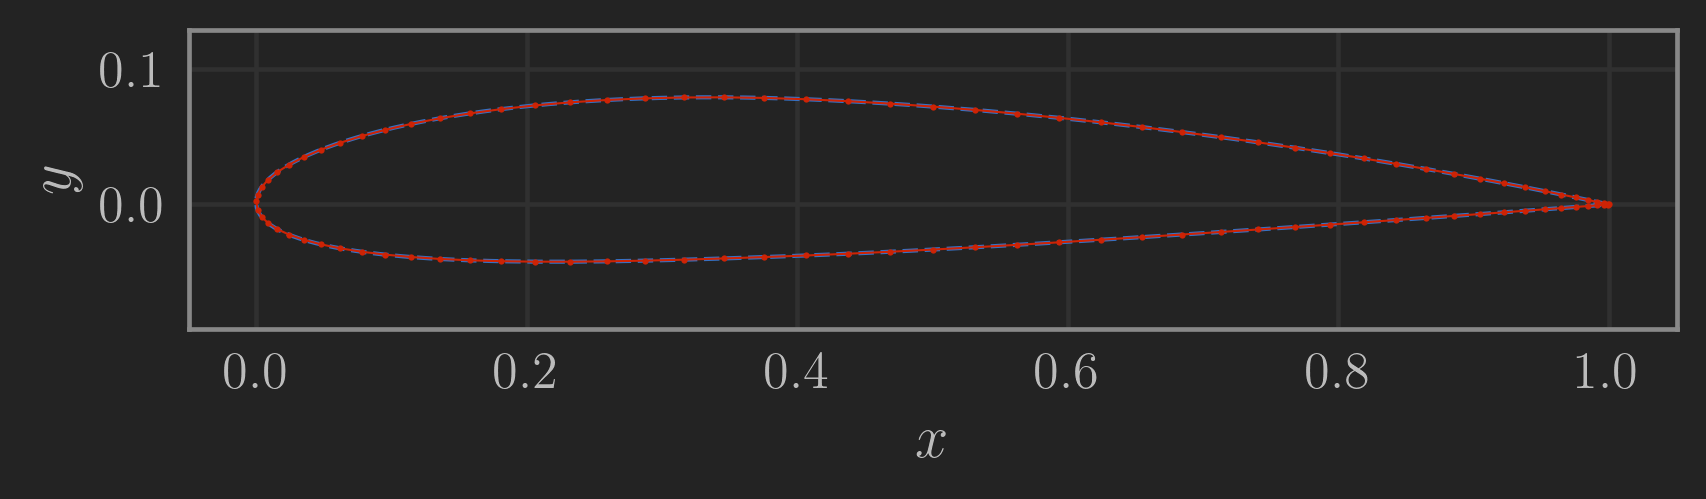

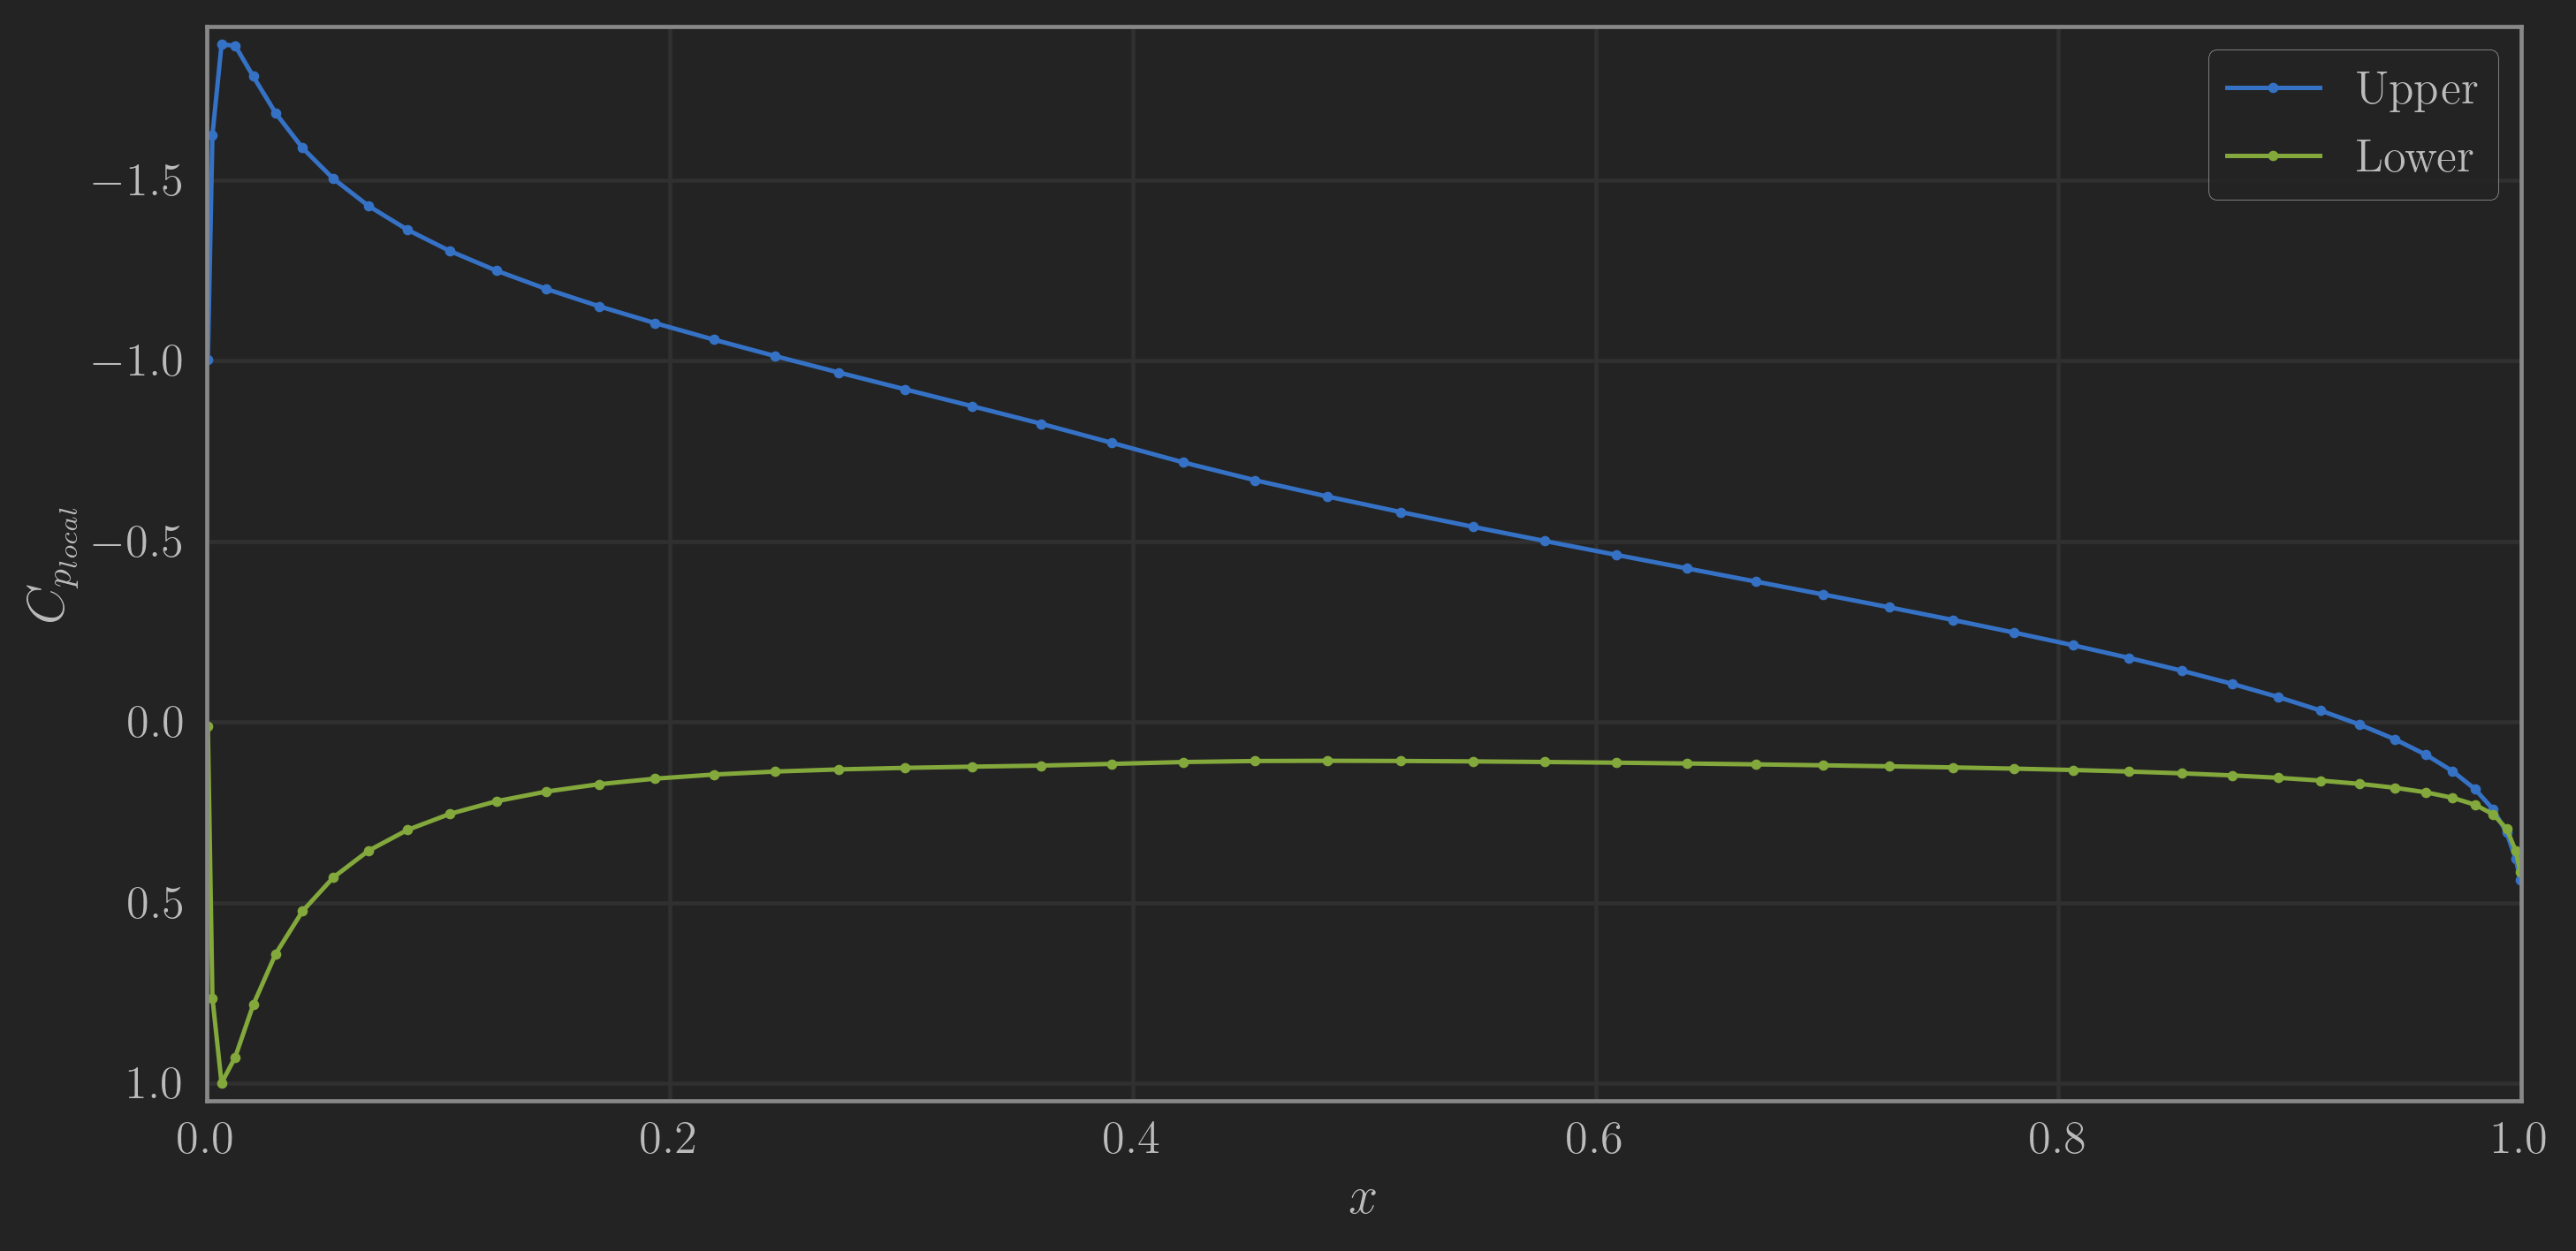

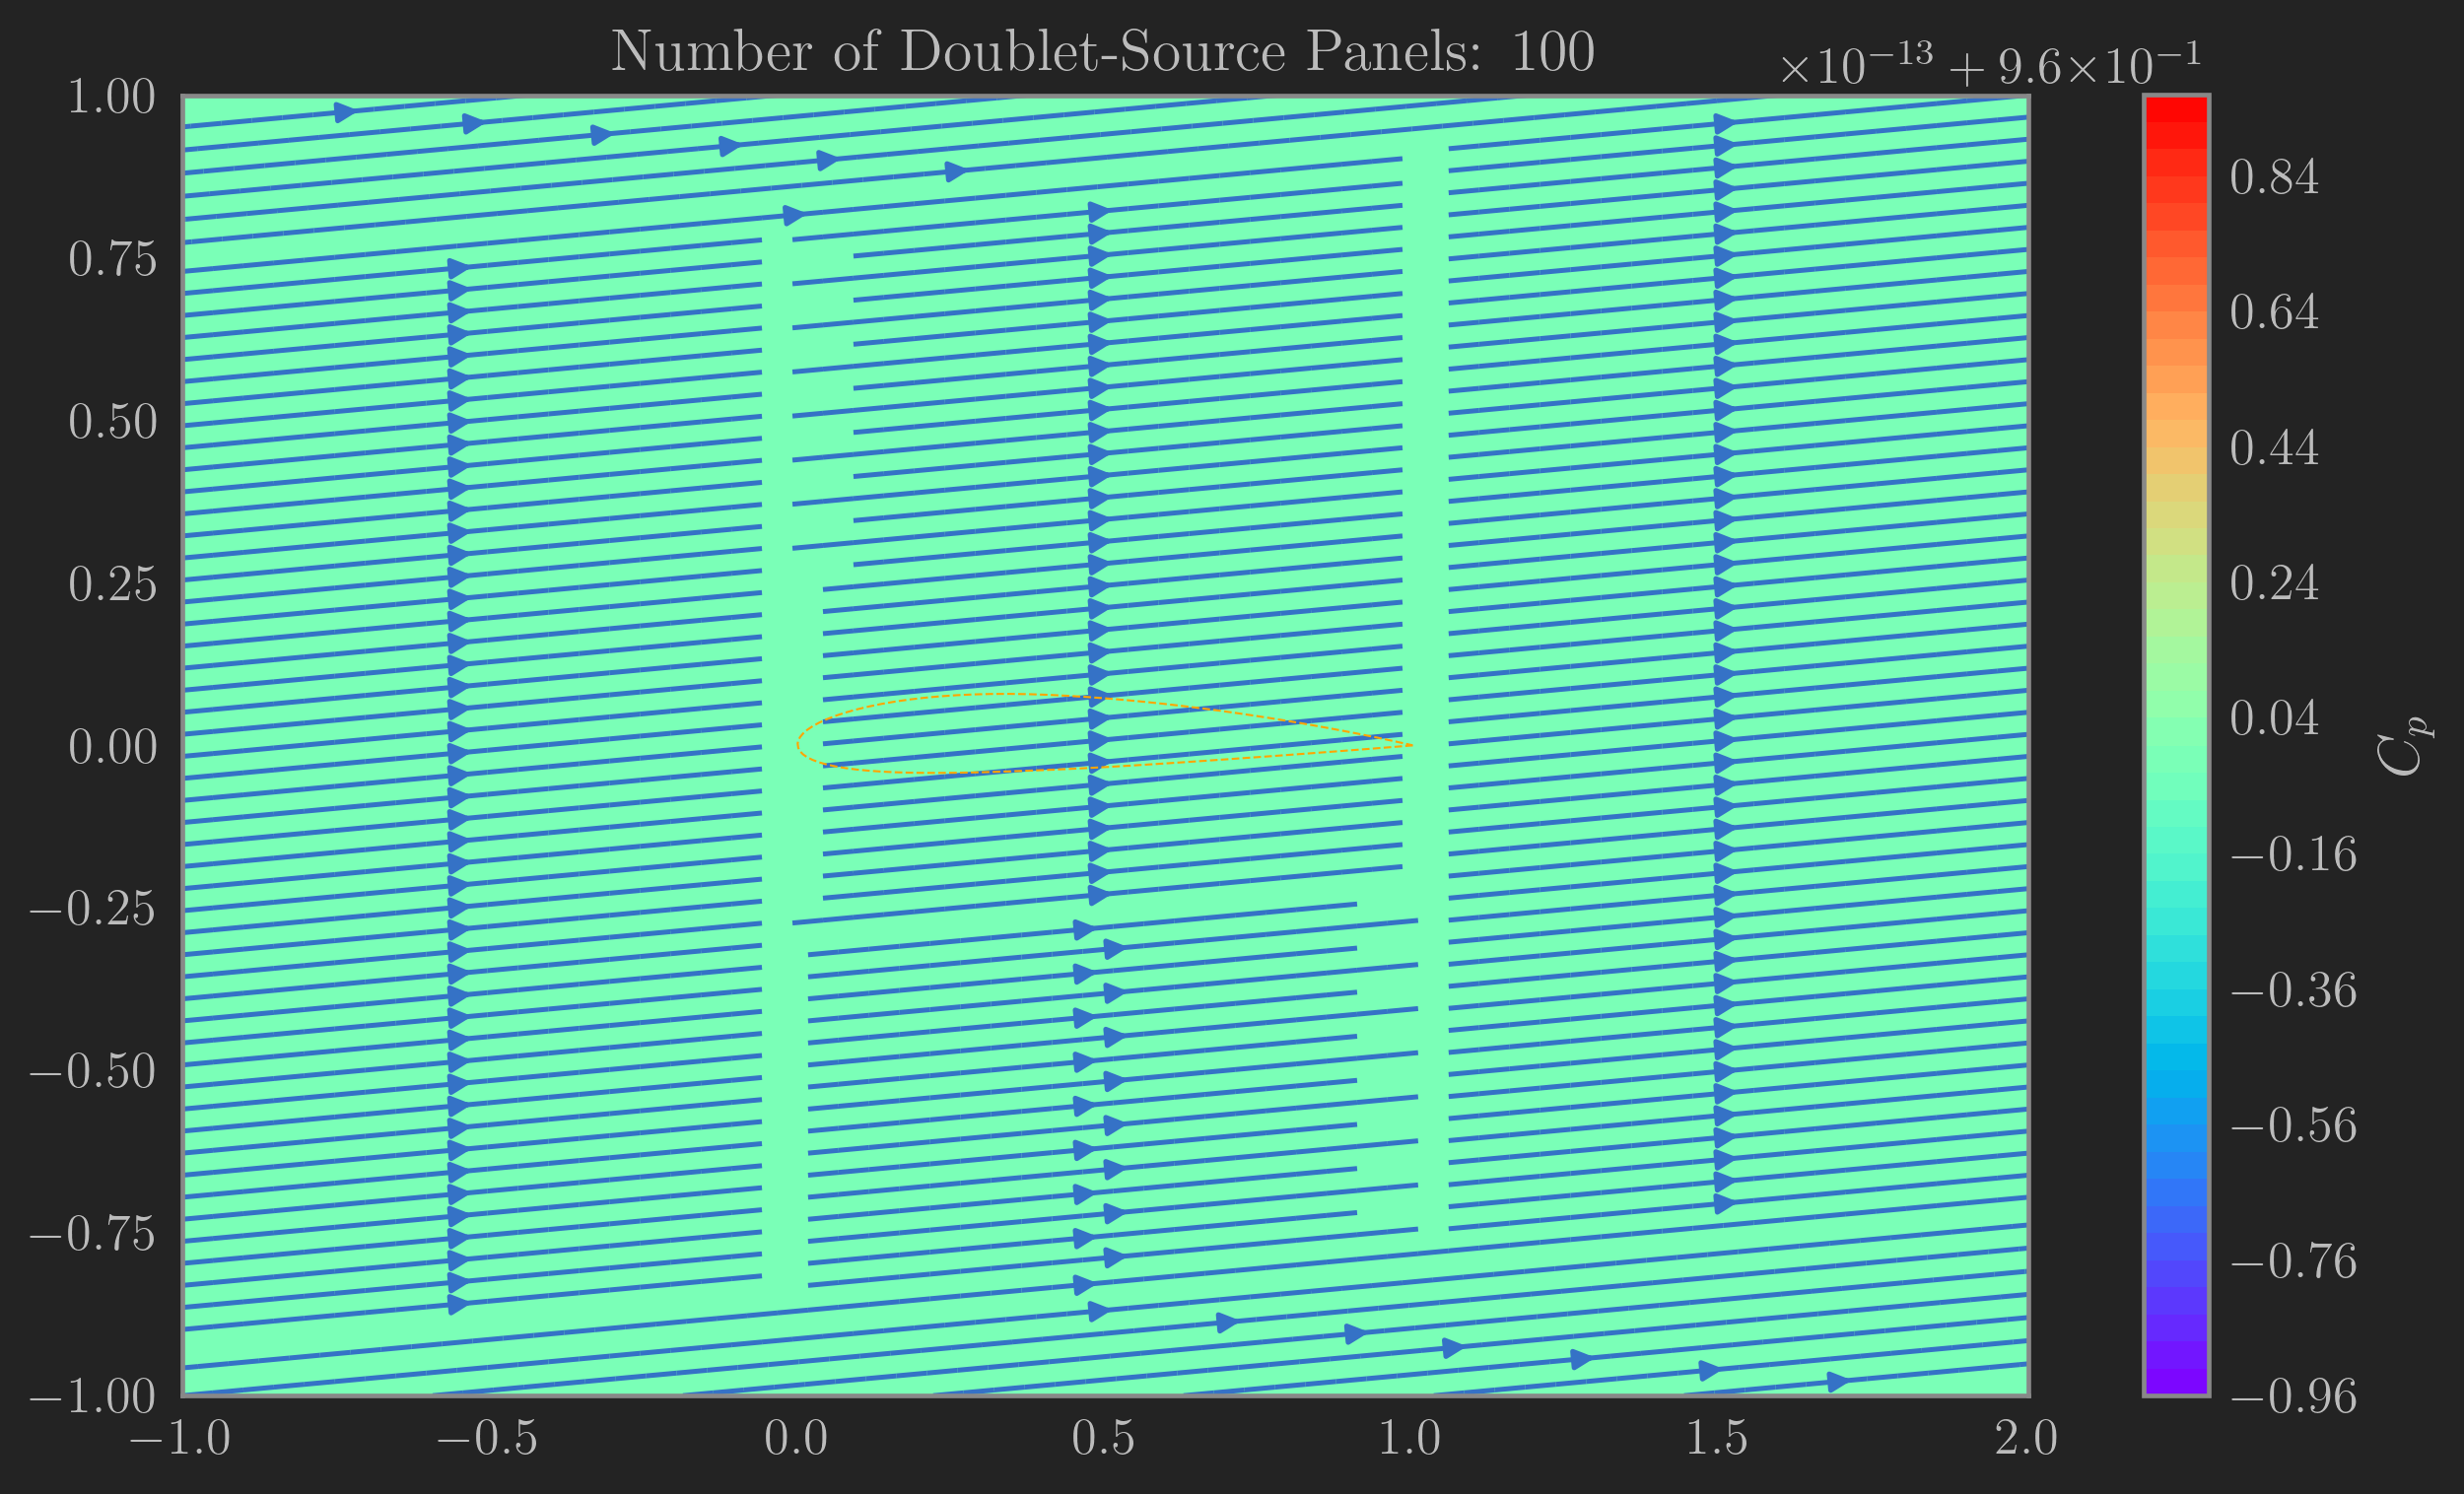

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [27]:
# Airfoil plotter
fig1 = figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.xs for panel in panels ], [ panel.ys for panel in panels ], linestyle="-", linewidth=0.5, marker=".", markersize=3, color="#CD2305")
axis("scaled")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

# Plot pressure coefficient
fig2 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend()
show()

# Plot flowfield
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig3 = figure(3, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
# fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([p.xs for p in panels], [p.ys for p in panels], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();